# Poem Generation using HMMs and RNNs

### Download Data

In [ ]:
import requests

url_dict = {
    'shakespeare.txt': 'https://caltech-cs155.s3.us-east-2.amazonaws.com/miniprojects/project3/data/shakespeare.txt',
    'spenser.txt': 'https://caltech-cs155.s3.us-east-2.amazonaws.com/miniprojects/project3/data/spenser.txt',
    'syllable_dict.txt' : 'https://caltech-cs155.s3.us-east-2.amazonaws.com/miniprojects/project3/data/Syllable_dictionary.txt',
    'about_syllable_dict.docx' : 'https://caltech-cs155.s3.us-east-2.amazonaws.com/miniprojects/project3/data/syllable_dict_explanation.docx',
    'hmm_add_text.pkl': 'https://drive.google.com/uc?export=download&id=1aaerDSNkXGvh62w6NjyvKM_SvNSiKKdg',
    'hmm1.pkl': 'https://drive.google.com/uc?export=download&id=1D4CzhGo60S8esZ65Hhlti8zM0Nv_sr75',
    'hmm2.pkl': 'https://drive.google.com/uc?export=download&id=1AOlRszGtCjn9Z7d4zO_fHq0Y039Yi1ls',
    'hmm4.pkl': 'https://drive.google.com/uc?export=download&id=1dcHkbxRo0S3p_P_3x-BMeUu61nqtkakm',
    'hmm8.pkl': 'https://drive.google.com/uc?export=download&id=1v7VOruONLKreW7fnLE8OFJuNQiCpAR8y',
    'hmm16.pkl': 'https://drive.google.com/uc?export=download&id=1OIv4tNiNUw-MAecnBsqbkwtpmryF8vVl',
    'rhyme_dict.pkl': 'https://drive.google.com/uc?export=download&id=1Bub7mi5wz8lqhYUKXw-7WqibneqUCzBY',
    'rnn_model.pkl': 'https://drive.google.com/uc?export=download&id=1-L6yhJBhQki_uJJOkwVDFvMl9DridWRO'
}

def download_file(file_path):
    url = url_dict[file_path]
    print('Start downloading...')
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(file_path, 'wb') as f:
            for chunk in r.iter_content(chunk_size=1024 * 1024 * 1024):
                f.write(chunk)
    print('Complete')

for key in url_dict:
    download_file(key)

Start downloading...
Complete
Start downloading...
Complete
Start downloading...
Complete
Start downloading...
Complete
Start downloading...
Complete
Start downloading...
Complete
Start downloading...
Complete
Start downloading...
Complete
Start downloading...
Complete
Start downloading...
Complete
Start downloading...
Complete
Start downloading...
Complete


### Importing packages \& Preprocessing

In [ ]:
!pip install dill
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import random
import os
import re
import urllib.request
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from matplotlib import animation
from matplotlib.animation import FuncAnimation
from tqdm import tqdm
import dill
import pickle

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 1.7 MB/s eta 0:00:00


# Implementing Models

## HMM Code

### Class

In [ ]:
class HiddenMarkovModel:
    '''
    Class implementation of Hidden Markov Models.
    '''

    def __init__(self, A, O):
        '''
        Initializes an HMM. Assumes the following:
            - States and observations are integers starting from 0.
            - There is a start state (see notes on A_start below). There
              is no integer associated with the start state, only
              probabilities in the vector A_start.
            - There is no end state.
        Arguments:
            A:          Transition matrix with dimensions L x L.
                        The (i, j)^th element is the probability of
                        transitioning from state i to state j. Note that
                        this does not include the starting probabilities.
            O:          Observation matrix with dimensions L x D.
                        The (i, j)^th element is the probability of
                        emitting observation j given state i.
        Parameters:
            L:          Number of states.

            D:          Number of observations.

            A:          The transition matrix.

            O:          The observation matrix.

            A_start:    Starting transition probabilities. The i^th element
                        is the probability of transitioning from the start
                        state to state i. For simplicity, we assume that
                        this distribution is uniform.
        '''

        self.L = len(A)
        self.D = len(O[0])
        self.A = A
        self.O = O
        self.A_start = [1. / self.L for _ in range(self.L)]


    def viterbi(self, x):
        '''
        Uses the Viterbi algorithm to find the max probability state
        sequence corresponding to a given input sequence.
        Arguments:
            x:          Input sequence in the form of a list of length M,
                        consisting of integers ranging from 0 to D - 1.
        Returns:
            max_seq:    State sequence corresponding to x with the highest
                        probability.
        '''

        M = len(x)      # Length of sequence.

        # The (i, j)^th elements of probs and seqs are the max probability
        # of the prefix of length i ending in state j and the prefix
        # that gives this probability, respectively.
        #
        # For instance, probs[1][0] is the probability of the prefix of
        # length 1 ending in state 0.
        probs = [[0. for _ in range(self.L)] for _ in range(M + 1)]
        seqs = [['' for _ in range(self.L)] for _ in range(M + 1)]

        for i in range(self.L):
          probs[1][i] = self.A_start[i] * self.O[i][x[0]]
          seqs[1][i] = str(i)


        for d in range(2, M + 1):

          for curr_state in range(self.L):
            max_prob = float("-inf")
            best_seq = ""

            for prev_state in range(self.L):
              prob = probs[d-1][prev_state] * self.A[prev_state][curr_state] * self.O[curr_state][x[d-1]]
              if prob >= max_prob:
                max_prob = prob
                best_seq = seqs[d-1][prev_state] + str(curr_state)

            probs[d][curr_state] = max_prob
            seqs[d][curr_state] = best_seq

        max_seq = seqs[M][np.argmax(probs[M])]
        return max_seq


    def forward(self, x, normalize=False):
        '''
        Uses the forward algorithm to calculate the alpha probability
        vectors corresponding to a given input sequence.
        Arguments:
            x:          Input sequence in the form of a list of length M,
                        consisting of integers ranging from 0 to D - 1.
            normalize:  Whether to normalize each set of alpha_j(i) vectors
                        at each i. This is useful to avoid underflow in
                        unsupervised learning.
        Returns:
            alphas:     Vector of alphas.
                        The (i, j)^th element of alphas is alpha_j(i),
                        i.e. the probability of observing prefix x^1:i
                        and state y^i = j.
                        e.g. alphas[1][0] corresponds to the probability
                        of observing x^1:1, i.e. the first observation,
                        given that y^1 = 0, i.e. the first state is 0.
        '''

        M = len(x)      # Length of sequence.
        alphas = [[0. for _ in range(self.L)] for _ in range(M + 1)]

        for i in range(self.L):
          alphas[1][i] = self.A_start[i] * self.O[i][x[0]]

        for d in range(2, M + 1):

          for curr_state in range(self.L):
            prob = 0
            for prev_state in range(self.L):
              prob += (self.O[curr_state][x[d-1]] * (alphas[d-1][prev_state] * self.A[prev_state][curr_state]))

            alphas[d][curr_state] = prob

          if normalize:
            denom = np.sum(alphas[d])
            alphas[d] = [alpha/denom for alpha in alphas[d]]


        return alphas


    def backward(self, x, normalize=False):
        '''
        Uses the backward algorithm to calculate the beta probability
        vectors corresponding to a given input sequence.
        Arguments:
            x:          Input sequence in the form of a list of length M,
                        consisting of integers ranging from 0 to D - 1.
            normalize:  Whether to normalize each set of alpha_j(i) vectors
                        at each i. This is useful to avoid underflow in
                        unsupervised learning.
        Returns:
            betas:      Vector of betas.
                        The (i, j)^th element of betas is beta_j(i), i.e.
                        the probability of observing prefix x^(i+1):M and
                        state y^i = j.
                        e.g. betas[M][0] corresponds to the probability
                        of observing x^M+1:M, i.e. no observations,
                        given that y^M = 0, i.e. the last state is 0.
        '''

        M = len(x)      # Length of sequence.
        betas = [[0. for _ in range(self.L)] for _ in range(M + 1)]

        for i in range(self.L):
          betas[M][i] = 1

        for d in range(M - 1, -1, -1):

          for curr_state in range(self.L):
            prob = 0
            for next_state in range(self.L):
                if d == 0:
                  prob += (betas[d+1][next_state] * self.A_start[next_state] * self.O[next_state][x[d]])
                else:
                  prob += (betas[d+1][next_state] * self.A[curr_state][next_state] * self.O[next_state][x[d]])

            betas[d][curr_state] = prob

          if normalize:
            denom = np.sum(betas[d])
            betas[d] = [beta/denom for beta in betas[d]]

        return betas


    def supervised_learning(self, X, Y):
        '''
        Trains the HMM using the Maximum Likelihood closed form solutions
        for the transition and observation matrices on a labeled
        datset (X, Y). Note that this method does not return anything, but
        instead updates the attributes of the HMM object.
        Arguments:
            X:          A dataset consisting of input sequences in the form
                        of lists of variable length, consisting of integers
                        ranging from 0 to D - 1. In other words, a list of
                        lists.
            Y:          A dataset consisting of state sequences in the form
                        of lists of variable length, consisting of integers
                        ranging from 0 to L - 1. In other words, a list of
                        lists.
                        Note that the elements in X line up with those in Y.
        '''

        # Calculate each element of A using the M-step formulas.
        for prev_state in range(self.L):
          for curr_state in range(self.L):
            numer_array = []
            denom_array = []

            for x in range(len(X)):
              for y in range(1, len(Y[x])):
                if Y[x][y] == curr_state and Y[x][y-1] == prev_state:
                  numer_array.append(1)
                else:
                  numer_array.append(0)

                if Y[x][y-1] == prev_state:
                  denom_array.append(1)
                else:
                  denom_array.append(0)

            numer = np.sum(numer_array)
            denom = np.sum(denom_array)
            self.A[prev_state][curr_state] = numer/denom

        # Calculate each element of O using the M-step formulas.
        for curr_state in range(self.L):
          for curr_obs in range(self.D):
            numer_array = []
            denom_array = []

            for x in range(len(X)):
              for y in range(len(Y[x])):
                if X[x][y] == curr_obs and Y[x][y] == curr_state:
                  numer_array.append(1)
                else:
                  numer_array.append(0)

                if Y[x][y] == curr_state:
                  denom_array.append(1)
                else:
                  denom_array.append(0)

            numer = np.sum(numer_array)
            denom = np.sum(denom_array)
            self.O[curr_state][curr_obs] = numer/denom


    def unsupervised_learning(self, X, N_iters):
        '''
        Trains the HMM using the Baum-Welch algorithm on an unlabeled
        datset X. Note that this method does not return anything, but
        instead updates the attributes of the HMM object.
        Arguments:
            X:          A dataset consisting of input sequences in the form
                        of variable-length lists, consisting of integers
                        ranging from 0 to D - 1. In other words, a list of
                        lists.
            N_iters:    The number of iterations to train on.
        '''

        for i in tqdm(range(N_iters)):
          A_numer = np.zeros((self.L, self.L))
          A_denom = np.zeros((self.L, self.L))
          O_numer = np.zeros((self.L, self.D))
          O_denom = np.zeros((self.L, self.D))

          for x in X:
            alphas = self.forward(x, normalize=True)
            betas = self.backward(x, normalize=True)
            M = len(x)

            for d in range(1, M + 1):
              prob_OAd = np.array([alphas[d][curr_state] * betas[d][curr_state] for curr_state in range(self.L)])
              prob_OAd /= np.sum(prob_OAd)

              for curr_state in range(self.L):
                O_numer[curr_state][x[d-1]] += prob_OAd[curr_state]
                O_denom[curr_state] += prob_OAd[curr_state]
                if d != M:
                  A_denom[curr_state] += prob_OAd[curr_state]

            for d in range(1, M):
              prob_An = np.array([[alphas[d][curr_state] \
                                  * self.O[next_state][x[d]] \
                                  * self.A[curr_state][next_state] \
                                  * betas[d+1][next_state] \
                                  for next_state in range(self.L)] \
                                  for curr_state in range(self.L)])
              prob_An /= np.sum(prob_An)

              for curr_state in range(self.L):
                for next_state in range(self.L):
                  A_numer[curr_state][next_state] += prob_An[curr_state][next_state]

          self.A = A_numer / A_denom
          self.O = O_numer / O_denom


    def generate_emission(self, M, seed=None):
        '''
        Generates an emission of length M, assuming that the starting state
        is chosen uniformly at random.
        Arguments:
            M:          Length of the emission to generate.
        Returns:
            emission:   The randomly generated emission as a list.
            states:     The randomly generated states as a list.
        '''

        # (Re-)Initialize random number generator
        rng = np.random.default_rng(seed=seed)

        emission = []
        states = []

        for i in range(M):
            if i == 0:
                state = rng.choice(self.L, p=self.A_start)
            else:
                state = rng.choice(self.L, p=self.A[states[-1]])
            emission.append(rng.choice(self.D, p=self.O[state]))
            states.append(state)

        return emission, states


    def probability_alphas(self, x):
        '''
        Finds the maximum probability of a given input sequence using
        the forward algorithm.
        Arguments:
            x:          Input sequence in the form of a list of length M,
                        consisting of integers ranging from 0 to D - 1.
        Returns:
            prob:       Total probability that x can occur.
        '''

        # Calculate alpha vectors.
        alphas = self.forward(x)

        # alpha_j(M) gives the probability that the state sequence ends
        # in j. Summing this value over all possible states j gives the
        # total probability of x paired with any state sequence, i.e.
        # the probability of x.
        prob = sum(alphas[-1])
        return prob


    def probability_betas(self, x):
        '''
        Finds the maximum probability of a given input sequence using
        the backward algorithm.
        Arguments:
            x:          Input sequence in the form of a list of length M,
                        consisting of integers ranging from 0 to D - 1.
        Returns:
            prob:       Total probability that x can occur.
        '''

        betas = self.backward(x)

        # beta_j(1) gives the probability that the state sequence starts
        # with j. Summing this, multiplied by the starting transition
        # probability and the observation probability, over all states
        # gives the total probability of x paired with any state
        # sequence, i.e. the probability of x.
        prob = sum([betas[1][j] * self.A_start[j] * self.O[j][x[0]] \
                    for j in range(self.L)])

        return prob


def supervised_HMM(X, Y):
    '''
    Helper function to train a supervised HMM. The function determines the
    number of unique states and observations in the given data, initializes
    the transition and observation matrices, creates the HMM, and then runs
    the training function for supervised learning.
    Arguments:
        X:          A dataset consisting of input sequences in the form
                    of lists of variable length, consisting of integers
                    ranging from 0 to D - 1. In other words, a list of lists.
        Y:          A dataset consisting of state sequences in the form
                    of lists of variable length, consisting of integers
                    ranging from 0 to L - 1. In other words, a list of lists.
                    Note that the elements in X line up with those in Y.
    '''
    # Make a set of observations.
    observations = set()
    for x in X:
        observations |= set(x)

    # Make a set of states.
    states = set()
    for y in Y:
        states |= set(y)

    # Compute L and D.
    L = len(states)
    D = len(observations)

    # Randomly initialize and normalize matrix A.
    A = [[random.random() for i in range(L)] for j in range(L)]

    for i in range(len(A)):
        norm = sum(A[i])
        for j in range(len(A[i])):
            A[i][j] /= norm

    # Randomly initialize and normalize matrix O.
    O = [[random.random() for i in range(D)] for j in range(L)]

    for i in range(len(O)):
        norm = sum(O[i])
        for j in range(len(O[i])):
            O[i][j] /= norm

    # Train an HMM with labeled data.
    HMM = HiddenMarkovModel(A, O)
    HMM.supervised_learning(X, Y)

    return HMM

def unsupervised_HMM(X, n_states, N_iters, seed=None):
    '''
    Helper function to train an unsupervised HMM. The function determines the
    number of unique observations in the given data, initializes
    the transition and observation matrices, creates the HMM, and then runs
    the training function for unsupervised learing.
    Arguments:
        X:          A dataset consisting of input sequences in the form
                    of lists of variable length, consisting of integers
                    ranging from 0 to D - 1. In other words, a list of lists.
        n_states:   Number of hidden states to use in training.

        N_iters:    The number of iterations to train on.
        rng:        The random number generator for reproducible result.
                    Default to RandomState(1).
    '''
    # Initialize random number generator
    rng = np.random.default_rng(seed=seed)

    # Make a set of observations.
    observations = set()
    for x in X:
        observations |= set(x)

    # Compute L and D.
    L = n_states
    D = len(observations)

    # Randomly initialize and normalize matrix A.
    A = [[rng.random() for i in range(L)] for j in range(L)]

    for i in range(len(A)):
        norm = sum(A[i])
        for j in range(len(A[i])):
            A[i][j] /= norm

    # Randomly initialize and normalize matrix O.
    O = [[rng.random() for i in range(D)] for j in range(L)]

    for i in range(len(O)):
        norm = sum(O[i])
        for j in range(len(O[i])):
            O[i][j] /= norm

    # Train an HMM with unlabeled data.
    HMM = HiddenMarkovModel(A, O)
    HMM.unsupervised_learning(X, N_iters)

    return HMM


####################
# WORDCLOUD FUNCTIONS
####################

def mask():
    # Parameters.
    r = 128
    d = 2 * r + 1

    # Get points in a circle.
    y, x = np.ogrid[-r:d-r, -r:d-r]
    circle = (x**2 + y**2 <= r**2)

    # Create mask.
    mask = 255 * np.ones((d, d), dtype=np.uint8)
    mask[circle] = 0

    return mask

def text_to_wordcloud(text, max_words=50, title='', show=True):
    plt.close('all')

    # Generate a wordcloud image.
    wordcloud = WordCloud(random_state=0,
                          max_words=max_words,
                          background_color='white',
                          mask=mask()).generate(text)

    # Show the image.
    if show:
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(title, fontsize=24)
        plt.show()

    return wordcloud

def states_to_wordclouds(hmm, obs_map, max_words=50, show=True):
    # Initialize.
    M = 100000
    n_states = len(hmm.A)
    obs_map_r = obs_map_reverser(obs_map)
    wordclouds = []

    # Generate a large emission.
    emission, states = hmm.generate_emission(M)

    # For each state, get a list of observations that have been emitted
    # from that state.
    obs_count = []
    for i in range(n_states):
        obs_lst = np.array(emission)[np.where(np.array(states) == i)[0]]
        obs_count.append(obs_lst)

    # For each state, convert it into a wordcloud.
    for i in range(n_states):
        obs_lst = obs_count[i]
        sentence = [obs_map_r[j] for j in obs_lst]
        sentence_str = ' '.join(sentence)

        wordclouds.append(text_to_wordcloud(sentence_str, max_words=max_words, title='State %d' % i, show=show))

    return wordclouds


####################
# HMM FUNCTIONS
####################

def parse_observations(text):
    # Convert text to dataset.
    lines = [line.split() for line in text.split('\n') if line.split()]

    obs_counter = 0
    obs = []
    obs_map = {}

    for line in lines:
        obs_elem = []

        for word in line:
            word = re.sub(r'[^\w]', '', word).lower()
            if word not in obs_map:
                # Add unique words to the observations map.
                obs_map[word] = obs_counter
                obs_counter += 1

            # Add the encoded word.
            obs_elem.append(obs_map[word])

        # Add the encoded sequence.
        obs.append(obs_elem)

    return obs, obs_map

def obs_map_reverser(obs_map):
    obs_map_r = {}

    for key in obs_map:
        obs_map_r[obs_map[key]] = key

    return obs_map_r

def sample_sentence(hmm, obs_map, n_words=100, seed=None):
    # Get reverse map.
    obs_map_r = obs_map_reverser(obs_map)

    # Sample and convert sentence.
    emission, states = hmm.generate_emission(n_words, seed=seed)
    sentence = [obs_map_r[i] for i in emission]

    return ' '.join(sentence).capitalize()


####################
# HMM VISUALIZATION FUNCTIONS
####################

def visualize_sparsities(hmm, O_max_cols=50, O_vmax=0.1):
    plt.close('all')
    plt.set_cmap('viridis')

    # Visualize sparsity of A.
    plt.imshow(hmm.A, vmax=1.0)
    plt.colorbar()
    plt.title('Sparsity of A matrix')
    plt.show()

    # Visualize parsity of O.
    plt.imshow(np.array(hmm.O)[:, :O_max_cols], vmax=O_vmax, aspect='auto')
    plt.colorbar()
    plt.title('Sparsity of O matrix')
    plt.show()


####################
# HMM ANIMATION FUNCTIONS
####################

def animate_emission(hmm, obs_map, M=8, height=12, width=12, delay=1, seed=None):
    # Parameters.
    lim = 1200
    text_x_offset = 40
    text_y_offset = 80
    x_offset = 580
    y_offset = 520
    R = 420
    r = 100
    arrow_size = 20
    arrow_p1 = 0.03
    arrow_p2 = 0.02
    arrow_p3 = 0.06

    # Initialize.
    n_states = len(hmm.A)
    obs_map_r = obs_map_reverser(obs_map)
    wordclouds = states_to_wordclouds(hmm, obs_map, max_words=20, show=False)

    # Initialize plot.
    fig, ax = plt.subplots()
    fig.set_figheight(height)
    fig.set_figwidth(width)
    ax.grid('off')
    plt.axis('off')
    ax.set_xlim([0, lim])
    ax.set_ylim([0, lim])

    # Plot each wordcloud.
    for i, wordcloud in enumerate(wordclouds):
        x = x_offset + int(R * np.cos(np.pi * 2 * i / n_states))
        y = y_offset + int(R * np.sin(np.pi * 2 * i / n_states))
        ax.imshow(wordcloud.to_array(), extent=(x - r, x + r, y - r, y + r), aspect='auto', zorder=-1)

    # Initialize text.
    text = ax.text(text_x_offset, lim - text_y_offset, '', fontsize=24)

    # Make the arrows.
    zorder_mult = n_states ** 2 * 100
    arrows = []
    for i in range(n_states):
        row = []
        for j in range(n_states):
            # Arrow coordinates.
            x_i = x_offset + R * np.cos(np.pi * 2 * i / n_states)
            y_i = y_offset + R * np.sin(np.pi * 2 * i / n_states)
            x_j = x_offset + R * np.cos(np.pi * 2 * j / n_states)
            y_j = y_offset + R * np.sin(np.pi * 2 * j / n_states)

            dx = x_j - x_i
            dy = y_j - y_i
            d = np.sqrt(dx**2 + dy**2)

            if i != j:
                arrow = ax.arrow(x_i + (r/d + arrow_p1) * dx + arrow_p2 * dy,
                                 y_i + (r/d + arrow_p1) * dy + arrow_p2 * dx,
                                 (1 - 2 * r/d - arrow_p3) * dx,
                                 (1 - 2 * r/d - arrow_p3) * dy,
                                 color=(1 - hmm.A[i][j], ) * 3,
                                 head_width=arrow_size, head_length=arrow_size,
                                 zorder=int(hmm.A[i][j] * zorder_mult))
            else:
                arrow = ax.arrow(x_i, y_i, 0, 0,
                                 color=(1 - hmm.A[i][j], ) * 3,
                                 head_width=arrow_size, head_length=arrow_size,
                                 zorder=int(hmm.A[i][j] * zorder_mult))

            row.append(arrow)
        arrows.append(row)

    emission, states = hmm.generate_emission(M, seed=seed)

    def animate(i):
        if i >= delay:
            i -= delay

            if i == 0:
                arrows[states[0]][states[0]].set_color('red')
            elif i == 1:
                arrows[states[0]][states[0]].set_color((1 - hmm.A[states[0]][states[0]], ) * 3)
                arrows[states[i - 1]][states[i]].set_color('red')
            else:
                arrows[states[i - 2]][states[i - 1]].set_color((1 - hmm.A[states[i - 2]][states[i - 1]], ) * 3)
                arrows[states[i - 1]][states[i]].set_color('red')

            # Set text.
            text.set_text(' '.join([obs_map_r[e] for e in emission][:i+1]).capitalize())

            return arrows + [text]

    # Animate!
    print('\nAnimating...')
    anim = FuncAnimation(fig, animate, frames=M+delay, interval=1000)

    return anim

class Utility:
    '''
    Utility for the problem files.
    '''

    def __init__():
        pass

    @staticmethod
    def load_sequence(n):
        '''
        Load the file 'sequence_data<n>.txt' for a given n.
        Arguments:
            n:          Sequence index.
        Returns:
            A:          The transition matrix.
            O:          The observation matrix.
            seqs:       Input sequences.
        '''
        A = []
        O = []
        seqs = []

        # For each file:
        with urllib.request.urlopen(f'https://caltech-cs155.s3.us-east-2.amazonaws.com/sets/set6/data/sequence_data{n}.txt') as f:
            # Read the parameters.
            L, D = [int(x) for x in f.readline().decode('utf-8').strip().split('\t')]

            # Read the transition matrix.
            for i in range(L):
                A.append([float(x) for x in f.readline().decode('utf-8').strip().split('\t')])

            # Read the observation matrix.
            for i in range(L):
                O.append([float(x) for x in f.readline().decode('utf-8').strip().split('\t')])

            # The rest of the file consists of sequences.
            while True:
                seq = f.readline().decode('utf-8').strip()
                if seq == '':
                    break
                seqs.append([int(x) for x in seq])

        return A, O, seqs

    @staticmethod
    def load_ron():
        '''
        Loads the file 'ron.txt'.
        Returns:
            moods:      Sequnces of states, i.e. a list of lists.
                        Each sequence represents half a year of data.
            mood_map:   A hash map that maps each state to an integer.
            genres:     Sequences of observations, i.e. a list of lists.
                        Each sequence represents half a year of data.
            genre_map:  A hash map that maps each observation to an integer.
        '''
        moods = []
        mood_map = {}
        genres = []
        genre_map = {}
        mood_counter = 0
        genre_counter = 0

        with urllib.request.urlopen("https://caltech-cs155.s3.us-east-2.amazonaws.com/sets/set6/data/ron.txt") as f:
            mood_seq = []
            genre_seq = []

            while True:
                line = f.readline().decode('utf-8').strip()

                if line == '' or line == '-':
                    # A half year has passed. Add the current sequence to
                    # the list of sequences.
                    moods.append(mood_seq)
                    genres.append(genre_seq)
                    # Start new sequences.
                    mood_seq = []
                    genre_seq = []

                if line == '':
                    break
                elif line == '-':
                    continue

                mood, genre = line.split()

                # Add new moods to the mood state hash map.
                if mood not in mood_map:
                    mood_map[mood] = mood_counter
                    mood_counter += 1

                mood_seq.append(mood_map[mood])

                # Add new genres to the genre observation hash map.
                if genre not in genre_map:
                    genre_map[genre] = genre_counter
                    genre_counter += 1

                # Convert the genre into an integer.
                genre_seq.append(genre_map[genre])

        return moods, mood_map, genres, genre_map

    @staticmethod
    def load_ron_hidden():
        '''
        Loads the file 'ron.txt' and hides the states.
        Returns:
            genres:     The observations.
            genre_map:  A hash map that maps each observation to an integer.
        '''
        moods, mood_map, genres, genre_map = Utility.load_ron()

        return genres, genre_map

### Learning and Sonnet Generation Part 1

In [ ]:
def generate_emission_from_word(hmm, word, obs_map, M, seed=None):
    A, O, L, D = hmm.A, hmm.O, hmm.L, hmm.D

    rng = np.random.default_rng(seed=seed)

    # Get initial state correspondingt to initial emission
    initial_emission = obs_map[word]
    initial_state = np.argmax(O[:, initial_emission])

    emission = [initial_emission]
    states = [initial_state]
    for i in range(M):
        state = rng.choice(L, p=A[states[-1]])
        emission.append(rng.choice(D, p=O[state]))
        states.append(state)

    return emission, states

def sample_line(hmm, syllable_dict, obs_map, n_syllables, seed=None, start_word=None):
    obs_map_r = obs_map_reverser(obs_map)

    n_words = n_syllables * 10

    if start_word is not None:
        emission, states = generate_emission_from_word(hmm, start_word.lower(), obs_map, n_words, seed=seed)
    else:
        emission, states = hmm.generate_emission(n_words, seed=seed)
    tot_syllables = 0
    line = []

    i = 0
    while tot_syllables < n_syllables:
        word = obs_map_r[emission[i]]
        if word not in syllable_dict:
            i += 1
            continue

        i_syllables = syllable_dict[word][0]
        if tot_syllables + i_syllables > n_syllables:
            if syllable_dict[word][1] is not None and tot_syllables + syllable_dict[word][1] <= n_syllables:
                i_syllables = syllable_dict[word][1]
                if tot_syllables + i_syllables > n_syllables:
                    i += 2
                    continue
            else:
                i += 2
                continue

        tot_syllables += i_syllables

        if len(line) == 0 or word == 'i':
            line.append(word.capitalize())
        else:
            line.append(word)
        i += 1

    return ' '.join(line)

def generate_sonnet_naive(hmm, syllable_dict, obs_map, seed):
    np.random.seed(seed)
    seed_add = np.random.randint(1000)

    sonnet = []
    for i in range(14):
        line = sample_line(hmm, syllable_dict, obs_map, 10, seed + i + seed_add)

        sonnet.append(line)
        if i % 4 == 3:
            sonnet[-1] += '\n'

        if i in [12, 13]:
            sonnet[-1] = '  ' + sonnet[-1]

    return sonnet

def parse_syllable_dict(filename):
    with open(filename, 'r') as f:
        lines = f.readlines()

    syllable_dict = {}
    for line in lines:
        line_split = line.split()
        if len(line_split) == 2:
            word, syllables = line_split
            syllable_dict[word] = [int(syllables), None]
        elif len(line_split) == 3:
            word, end_syllables, syllables = line_split
            if 'E' not in end_syllables and 'E' in syllables:
                syllables, end_syllables = end_syllables, syllables
            end_syllables = int(end_syllables[1:]) if end_syllables[0] == 'E' else int(end_syllables)
            syllable_dict[word] = [int(syllables), end_syllables]

    return syllable_dict

def get_text(filename):
    text = open(filename, 'r').read()
    text = [x for x in text.split('\n') if len(x.split()) > 1]   # Remove empty and single word lines
    return '\n'.join(text)

def print_poem(poem):
    for line in poem:
        print(line)

def save_model(hmm, filename):
    with open(filename, 'wb') as f:
        dill.dump(hmm, f)

def load_model(filename):
    with open(filename, 'rb') as f:
        return dill.load(f)

In [ ]:
syllable_dict = parse_syllable_dict('syllable_dict.txt')
obs, obs_map = parse_observations(get_text('shakespeare.txt'))

In [ ]:
# Train HMM models
# for num_states in [24, 32]:
#     hmm = unsupervised_HMM(obs, num_states, num_iterations, seed=1)
#     save_model(hmm, f'hmm{num_states}.pkl')

In [ ]:
hmm = load_model('hmm8.pkl')

In [ ]:
sonnet = generate_sonnet_naive(hmm, syllable_dict, obs_map, seed=0)
print_poem(sonnet)

For falsehood in thou herald so in thou
Though when gone in die house compounds will a
For but that their power party all yet as
First state it eye love on say which substance

See I to from my love that time unlooked
Your sweet almost thou whose attending place
Urge thy fairest doth had quite set me to
It painted child again sight nor to a

To my be glad fair love another he
Thy verse were my eyes canopy life of
Sap none hate tables truth or as then her
Be invent most state title abused me

  And else best a riches doth lies winters
  Will since my fever self that to their nothing


In [ ]:
for size in [1, 2, 4, 8, 16]:
    try:
        print(f'Hidden states: {size}')
        hmm = load_model(f'hmm{size}.pkl')
        sonnet = generate_sonnet_naive(hmm, syllable_dict, obs_map, seed=0)
        print_poem(sonnet)
        print()
    except:
        pass

Hidden states: 1
Orient found shall with should how or self is
Scythe being of on might babe faith my all
Was but that you trifle whether make of
Leisure ere holy and love those my it

Having doth where desire what for that to
As seen a this eternal hast water
Besides thee from get leaves love took love too
Despite deeds art heart my o with perfumes

Thy her thou once is nothing their thee men
Thy sight upon they that less face of both
Me not men transferred no of as if life
Of plea knows let dully ruined purpose

  In memory touches days record than
  My heaven they balmy but that sweet you

Hidden states: 2
Way nights will a his fair be too truth this
Your lusty all of but seem faith my say
Still the but lease prey cannot excuse of
Lest every lover spring such give my look

Upon he to we hours she never
Whilst that shine self thee truth love motion in
Objects so from life though hate present change
Gives amiss and rehearse my I a more

Thou for the therefore not he one so drawn
With 

## RNN Code

In [ ]:
def parse_observations_char(text):
    lines = [list(line) for line in text.split('\n')]
    obs_counter = 0
    obs = []
    obs_map = {}

    for line in lines:
        obs_elem = []

        for word in line:
            if word not in obs_map:
                obs_map[word] = obs_counter
                obs_counter += 1

            obs_elem.append(obs_map[word])

        if '\n' not in obs_map:
          obs_map['\n'] = obs_counter
          obs_counter += 1
          obs_elem.append(obs_map['\n'])

        obs.append(obs_elem)

    return obs, obs_map

shakespeare = open('shakespeare.txt', 'r').read()
text = [x for x in shakespeare.split('\n') if len(x.split()) > 1]
text_join = (" ").join(text)
ob, obs_map = parse_observations_char('\n'.join(text))
seq_length = 40
sequences = []
labels = []

for i in range(0, len(text_join) - seq_length, 5):
    seq = text_join[i:i+seq_length]
    target = text_join[i+seq_length]
    curr = []

    sequences.append(seq)
    labels.append(target)

input_sequences = []
for seq in sequences:
  char_to_num = []
  for char in seq:
    char_to_num.append(obs_map[char])
  input_sequences.append(char_to_num)

one_hot_sequences = np.zeros((len(input_sequences), seq_length, len(obs_map)))

for i, sequence in enumerate(input_sequences):
  for j, char in enumerate(sequence):
     one_hot_sequences[i][j][char] = 1

true_labels = []
for val in labels:
  true_labels.append(obs_map[val])

one_hot_labels = np.zeros((len(labels), len(obs_map)))

for i, label in enumerate(true_labels):
  one_hot_labels[i][label] = 1

In [ ]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden):
        output = self.lstm(input.view(1, 1, -1), hidden)[0]
        output = self.linear(output.view(1, -1))
        return output

    def initHidden(self, hidden_size):
      (torch.zeros(1, 1, hidden_size), torch.zeros(1, 1, hidden_size))

all_characters = obs_map.keys()
num_chars = len(all_characters)

hidden_size = 180
learning_rate = 0.005
sequence_length = 40
epochs = 10000

model = RNN(num_chars, hidden_size, num_chars)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [ ]:
def generate_poem(model, seed, temperature, length):
    with torch.no_grad():
        hidden = model.initHidden(hidden_size)
        poem = seed

        for _ in range(length):
            seed_mappings = []
            for char in seed:
                seed_mappings.append(obs_map[char])

            one_hot_sequence = np.zeros((len(seed), len(obs_map)))

            for i, char in enumerate(seed_mappings):
                one_hot_sequence[i][char] = 1

            input_tensor = torch.tensor(one_hot_sequence, dtype=torch.float)
            output = model(input_tensor[0], hidden)

            new = output[0].detach().numpy()
            summation = 0

            for element in new:
                summation += np.exp(element / temperature)

            for index, element in enumerate(new):
                new[index] = np.exp(element / temperature) / summation

            output[0] = torch.tensor(new, dtype=torch.float)
            predicted_char_index = torch.multinomial(output, 1)[0]
            predicted_char = ""

            for key in obs_map:
                if obs_map[key] == predicted_char_index:
                    predicted_char = key

            seed = predicted_char
            poem += predicted_char

        return poem


In [ ]:
rnn = load_model('rnn_model.pkl')

In [ ]:
generated_poem = generate_poem(rnn, "shall i compare thee to a summer's day?\n", 1.5, 200)
print(generated_poem)

shall i compare thee to a summer's day?
he nve l my'r, mye,n dvook, t t: aidongrtakije Not t: k d, fanis reto s. boI Kimatght? Ylsorgis Plfe. my myof tronag, howe he,'s O w  Ansattth r we, quce ale , b: ct, D,  dgallond, ghoughe, tcarithot 


In [ ]:
generated_poem = generate_poem(rnn, "shall i compare thee to a summer's day?\n", 0.75, 200)
print(generated_poem)

shall i compare thee to a summer's day?
 the, mis oure, illore llllecer mpave Anerelou che, ate thers by sout ly, as orest my  the An arereline chy igre, by orons  eck, the arseatha seric d delend fer t ar nin orerede, d f thist t th s t it


In [ ]:
generated_poem = generate_poem(rnn, "shall i compare thee to a summer's day?\n", 0.25, 200)
print(generated_poem)

shall i compare thee to a summer's day?
 the than my the the the s the the the the ther the the there the the the the th the the me the the the the the then the thond the the the an the thin t in the than the the th thar the the the the the


## Sonnet Generation

In [ ]:
def generate_sonnet_rhyme(hmm, syllable_dict, rhyme_dict, obs_map, seed=None):
    np.random.seed(seed)
    pair_seeds = np.random.randint(1000, size=7)

    line_pairs = []
    for i in range(7):
        pair_seed = pair_seeds[i]
        lever = True
        while lever:
            line1 = sample_line(hmm, syllable_dict, obs_map, 10, pair_seed).lower().split()
            last_word = line1[-1]
            if len(rhyme_dict[last_word]) == 0:
                pair_seed += 1
                continue

            np.random.seed(pair_seed)
            rhyming_word = np.random.choice(list(rhyme_dict[last_word]))
            if rhyming_word in syllable_dict:
                lever = False
            else:
                pair_seed += 1

        line2 = sample_line(hmm, syllable_dict, obs_map, 10, pair_seed, start_word=rhyming_word).lower().split()[::-1]


        for i, word in enumerate(line1):
            if word == 'i' or i == 0:
                line1[i] = word.capitalize()

        for i, word in enumerate(line2):
            if word == 'i' or i == 0:
                line2[i] = word.capitalize()

        line1 = ' '.join(line1)
        line2 = ' '.join(line2)

        line_pairs.append((line1, line2))

    sonnet = [None] * 14

    sonnet[0] = line_pairs[0][0]
    sonnet[1] = line_pairs[1][0]
    sonnet[2] = line_pairs[0][1]
    sonnet[3] = line_pairs[1][1] + '\n'

    sonnet[4] = line_pairs[2][0]
    sonnet[5] = line_pairs[3][0]
    sonnet[6] = line_pairs[2][1]
    sonnet[7] = line_pairs[3][1] + '\n'

    sonnet[8] = line_pairs[4][0]
    sonnet[9] = line_pairs[5][0]
    sonnet[10] = line_pairs[4][1]
    sonnet[11] = line_pairs[5][1] + '\n'

    sonnet[12] = '  ' + line_pairs[6][0]
    sonnet[13] = '  ' + line_pairs[6][1]

    return sonnet


In [ ]:
from collections import defaultdict
import nltk
import re
from tqdm import tqdm
import pickle

def tokenize(text):
    tokens = re.findall(r"\b[\w']+\b", text)
    # tokens = re.findall(r'\b\w+\b', text)
    return tokens

def rhyme(inp, level):
    entries = nltk.corpus.cmudict.entries()
    syllables = [(word, syl) for word, syl in entries if word == inp]
    rhymes = set()
    for (word, syllable) in syllables:
        rhymes.update({word for word, pron in entries if pron[-level:] == syllable[-level:] and word != inp})
    return rhymes

def doTheyRhyme(word1, word2, rhyme2):
    if word1.find(word2) == len(word1) - len(word2):
        return False
    if word2.find(word1) == len(word2) - len(word1):
        return False

    return word1 in rhyme2

def identify_rhyme_scheme(poem, level=2):
    tokens = tokenize(poem)

    rhyme_dict = defaultdict(list)
    for token in tqdm(tokens):
        rhyme_dict[token.lower()] = rhyme(token.lower(), level)

    return rhyme_dict

In [ ]:
syllable_dict = parse_syllable_dict('syllable_dict.txt')
obs, obs_map = parse_observations(get_text('shakespeare.txt'))
hmm = load_model('hmm8.pkl')
rhyme_dict = pickle.load(open('rhyme_dict.pkl', 'rb'))

sonnet = generate_sonnet_rhyme(hmm, syllable_dict, rhyme_dict, obs_map, seed=0)
print_poem(sonnet)

Though when gone in die house compounds will a
That to whose loves fiend thine full to to not
Your physic stay self in eye be grace ay
To full thine fiend loves doth treasure that spot

Though when gone in die house compounds will a
Blind should I every image and be by
Your physic stay self in eye be grace ay
Be and image every I as heart buy

That all they of none can thinking by I
Of my art immured shifting conspire
By thinking can none of they all that eye
My am inherit the I when desire

  Indigest false creatures is down some love
  Where I give slumbers is yet mar above


## Visualization

In [ ]:
spenser = open('spenser.txt', 'r').read()
text2 = [x for x in spenser.split('\n') if len(x.split()) > 1]   # Remove empty and single word lines
obs2, obs_map2 = parse_observations('\n'.join(text).join(text2))

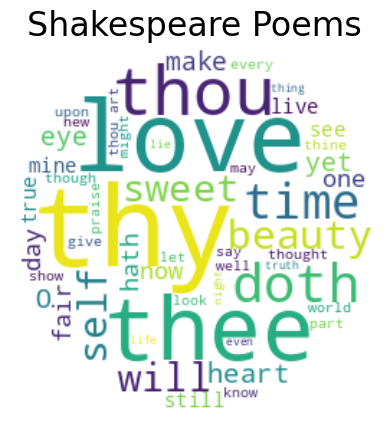

In [ ]:
shakespeare_wordcloud = text_to_wordcloud(shakespeare, title='Shakespeare Poems')

In [ ]:
hmm1 = load_model("hmm1.pkl")
hmm2 = load_model("hmm2.pkl")
hmm4 = load_model("hmm4.pkl")
hmm8 = load_model("hmm8.pkl")
hmm16 = load_model("hmm16.pkl")
hmm_add = load_model("hmm_add_text.pkl")

In [ ]:
import nltk
from itertools import groupby, islice
import json
from pprint import pprint
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('tagsets')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package tagsets to /root/nltk_data...
[nltk_data]   Unzipping help/tagsets.zip.


True

In [ ]:
def states_to_POS(hmm, obs_map, max_words=50, show=True):
    # Initialize.
    M = 100000
    n_states = len(hmm.A)
    obs_map_r = obs_map_reverser(obs_map)
    tagged_states = []

    # Generate a large emission.
    emission, states = hmm.generate_emission(M)

    # For each state, get a list of observations that have been emitted
    # from that state.
    obs_count = []
    for i in range(n_states):
        obs_lst = np.array(emission)[np.where(np.array(states) == i)[0]]
        obs_count.append(obs_lst)

    # For each state, convert it into a wordcloud.
    for i in range(n_states):
        obs_lst = obs_count[i]
        sentence = [obs_map_r[j] for j in obs_lst]
        sentence_str = ' '.join(sentence)

        text = nltk.word_tokenize(sentence_str)
        tagged = nltk.pos_tag(text)
        tagged_states.append(tagged)

    return tagged_states

In [ ]:
def visualize_pos(state_pos, tagdict):
  for i in range(len(state_pos)):
    y = np.array([j[1] for j in state_pos[i]])
    freq = {key:len(list(group)) for key, group in groupby(np.sort(y))}
    top_10 = dict(sorted(freq.items(), key=lambda item: item[1], reverse=True))
    top_10 = dict(islice(top_10.items(), 10))
    y_meaning = np.array([tagdict[j][0] for j in top_10.keys()])
    y_dict = dict(zip(top_10.keys(), y_meaning))

    f, ax = plt.subplots()

    plt.bar(top_10.keys(), top_10.values())
    plt.title("Top 10 Parts of Speech of State " + str(i))
    plt.xlabel("Part of Speech")
    plt.ylabel("Frequency")

    plt.show()
    pprint(y_dict)

In [ ]:
tagdict = nltk.data.load('help/tagsets/upenn_tagset.pickle')

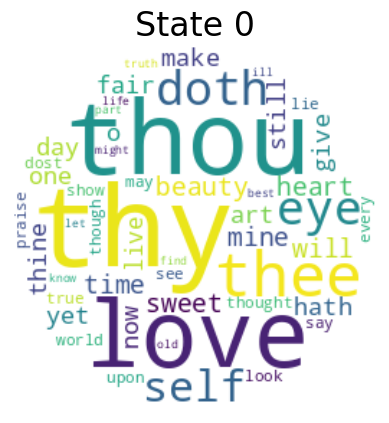

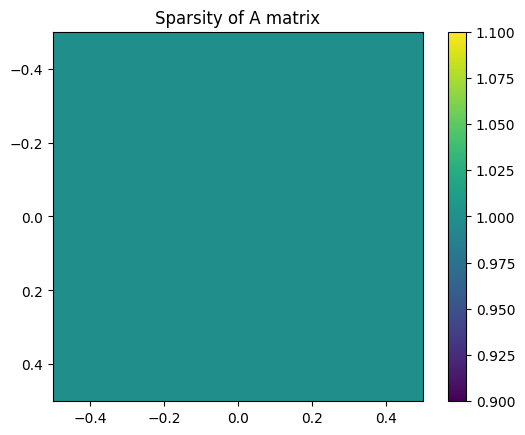

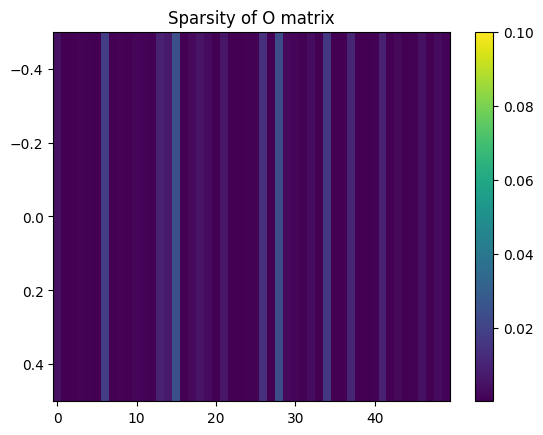

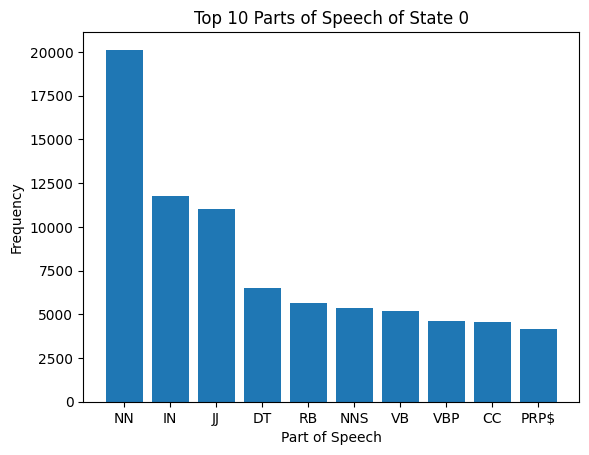

{'CC': 'conjunction, coordinating',
 'DT': 'determiner',
 'IN': 'preposition or conjunction, subordinating',
 'JJ': 'adjective or numeral, ordinal',
 'NN': 'noun, common, singular or mass',
 'NNS': 'noun, common, plural',
 'PRP$': 'pronoun, possessive',
 'RB': 'adverb',
 'VB': 'verb, base form',
 'VBP': 'verb, present tense, not 3rd person singular'}


In [ ]:
wordcloud1 = states_to_wordclouds(hmm1, obs_map)
visualize_sparsities(hmm1, O_max_cols=50)
pos = states_to_POS(hmm1, obs_map)
visualize_pos(pos, tagdict)

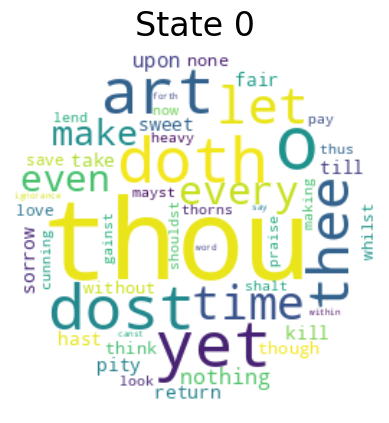

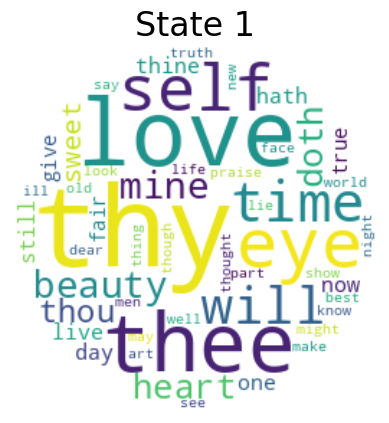

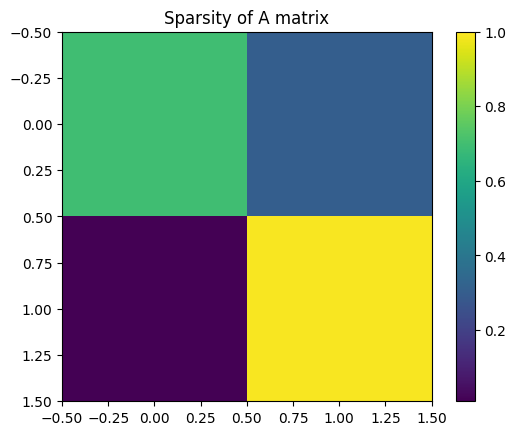

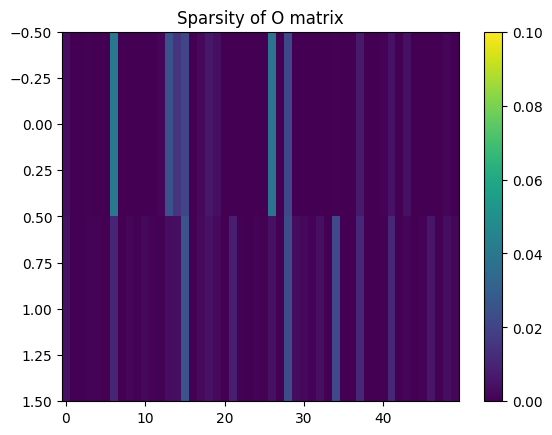

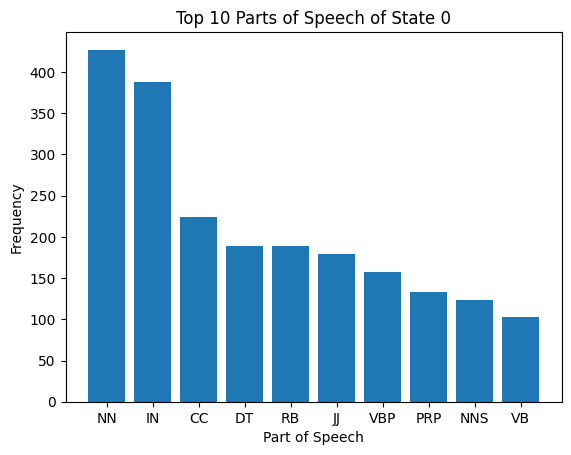

{'CC': 'conjunction, coordinating',
 'DT': 'determiner',
 'IN': 'preposition or conjunction, subordinating',
 'JJ': 'adjective or numeral, ordinal',
 'NN': 'noun, common, singular or mass',
 'NNS': 'noun, common, plural',
 'PRP': 'pronoun, personal',
 'RB': 'adverb',
 'VB': 'verb, base form',
 'VBP': 'verb, present tense, not 3rd person singular'}


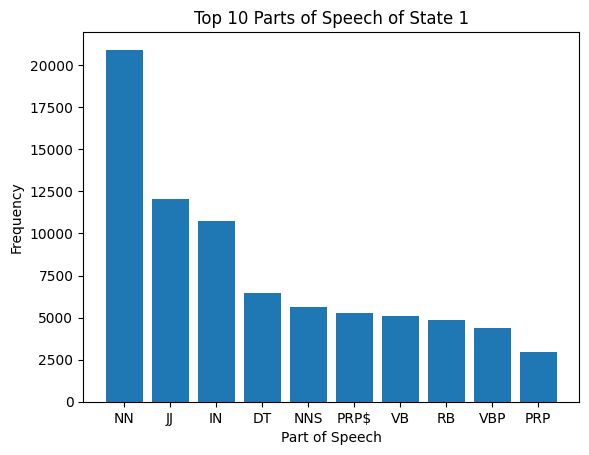

{'DT': 'determiner',
 'IN': 'preposition or conjunction, subordinating',
 'JJ': 'adjective or numeral, ordinal',
 'NN': 'noun, common, singular or mass',
 'NNS': 'noun, common, plural',
 'PRP': 'pronoun, personal',
 'PRP$': 'pronoun, possessive',
 'RB': 'adverb',
 'VB': 'verb, base form',
 'VBP': 'verb, present tense, not 3rd person singular'}


In [ ]:
wordcloud2 = states_to_wordclouds(hmm2, obs_map)
visualize_sparsities(hmm2, O_max_cols=50)
pos2 = states_to_POS(hmm2, obs_map)
visualize_pos(pos2, tagdict)

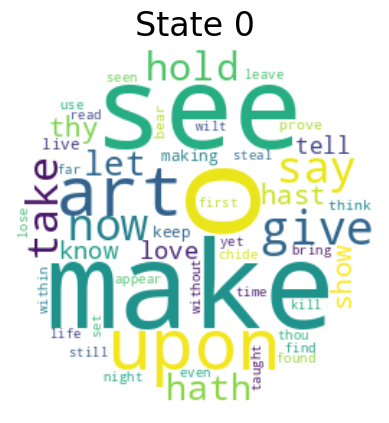

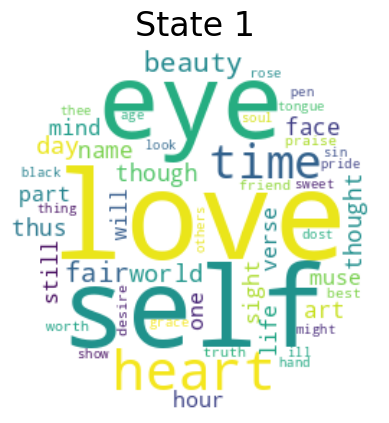

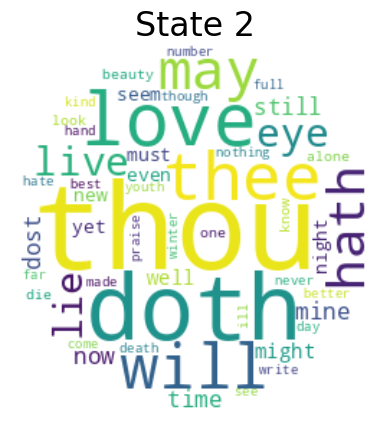

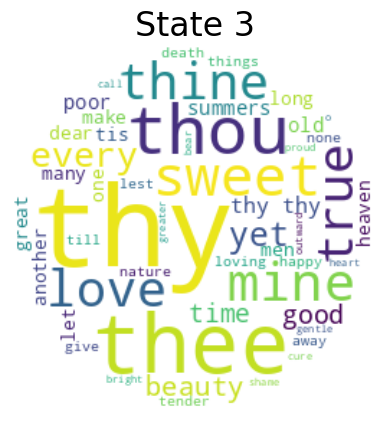

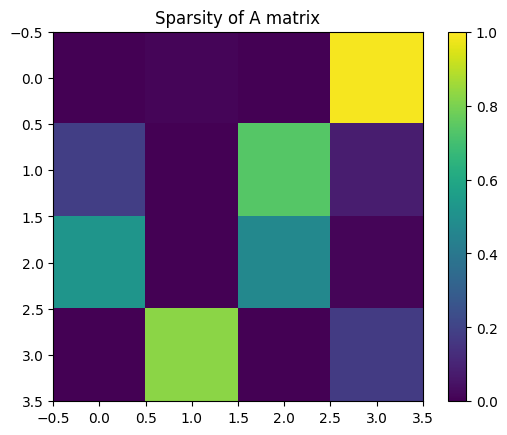

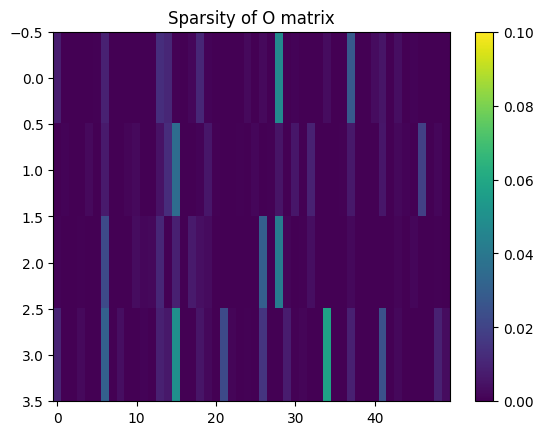

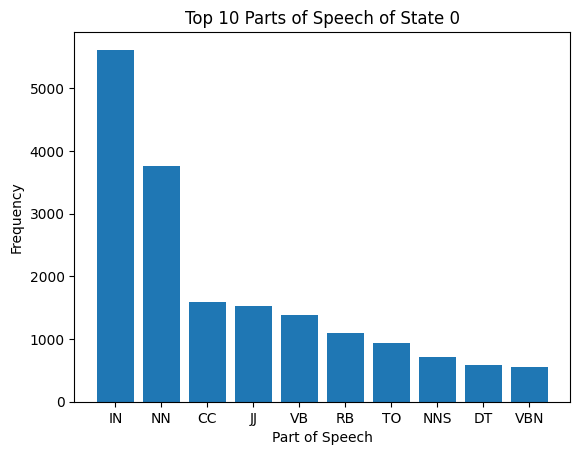

{'CC': 'conjunction, coordinating',
 'DT': 'determiner',
 'IN': 'preposition or conjunction, subordinating',
 'JJ': 'adjective or numeral, ordinal',
 'NN': 'noun, common, singular or mass',
 'NNS': 'noun, common, plural',
 'RB': 'adverb',
 'TO': '"to" as preposition or infinitive marker',
 'VB': 'verb, base form',
 'VBN': 'verb, past participle'}


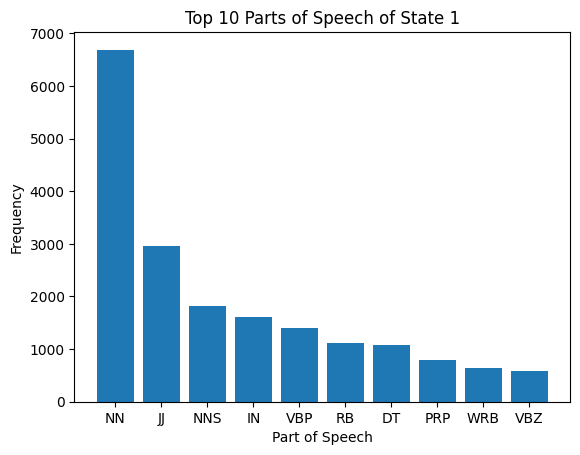

{'DT': 'determiner',
 'IN': 'preposition or conjunction, subordinating',
 'JJ': 'adjective or numeral, ordinal',
 'NN': 'noun, common, singular or mass',
 'NNS': 'noun, common, plural',
 'PRP': 'pronoun, personal',
 'RB': 'adverb',
 'VBP': 'verb, present tense, not 3rd person singular',
 'VBZ': 'verb, present tense, 3rd person singular',
 'WRB': 'Wh-adverb'}


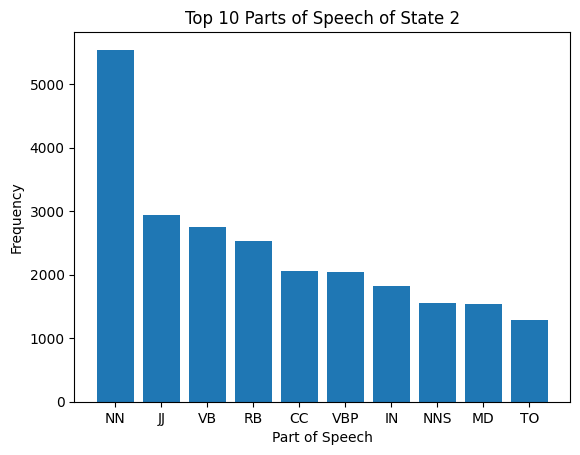

{'CC': 'conjunction, coordinating',
 'IN': 'preposition or conjunction, subordinating',
 'JJ': 'adjective or numeral, ordinal',
 'MD': 'modal auxiliary',
 'NN': 'noun, common, singular or mass',
 'NNS': 'noun, common, plural',
 'RB': 'adverb',
 'TO': '"to" as preposition or infinitive marker',
 'VB': 'verb, base form',
 'VBP': 'verb, present tense, not 3rd person singular'}


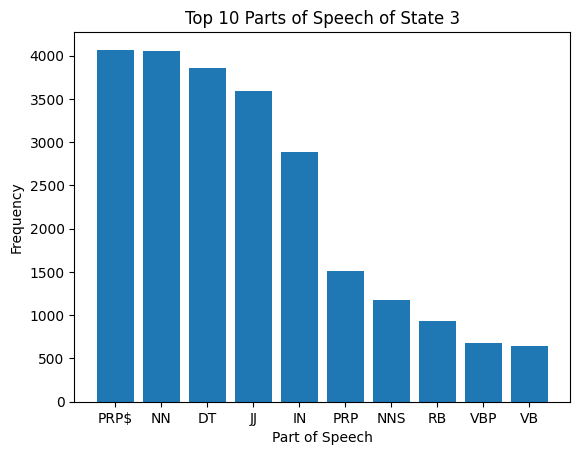

{'DT': 'determiner',
 'IN': 'preposition or conjunction, subordinating',
 'JJ': 'adjective or numeral, ordinal',
 'NN': 'noun, common, singular or mass',
 'NNS': 'noun, common, plural',
 'PRP': 'pronoun, personal',
 'PRP$': 'pronoun, possessive',
 'RB': 'adverb',
 'VB': 'verb, base form',
 'VBP': 'verb, present tense, not 3rd person singular'}


In [ ]:
wordcloud4 = states_to_wordclouds(hmm4, obs_map)
visualize_sparsities(hmm4, O_max_cols=50)
pos4 = states_to_POS(hmm4, obs_map)
visualize_pos(pos4, tagdict)

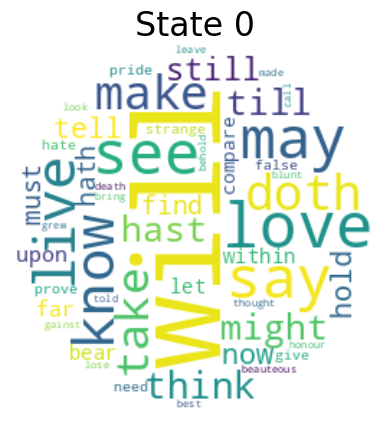

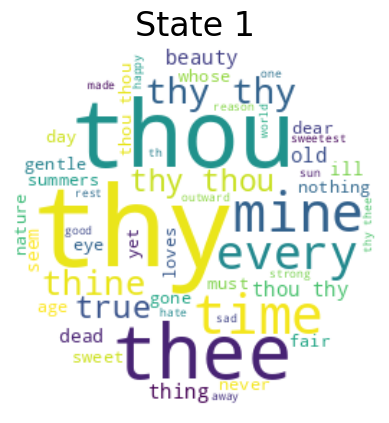

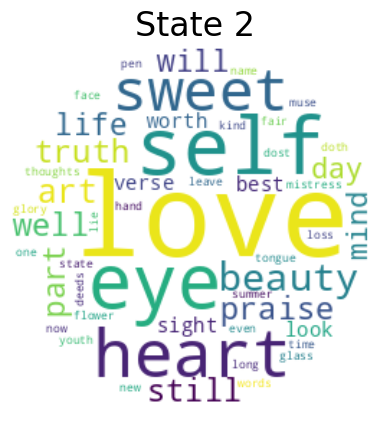

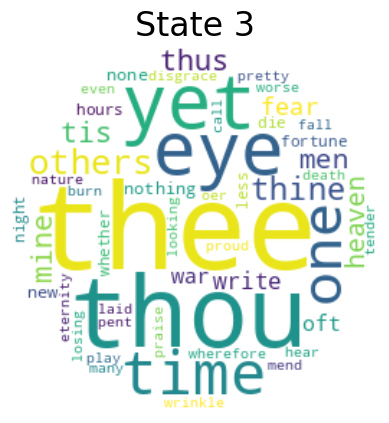

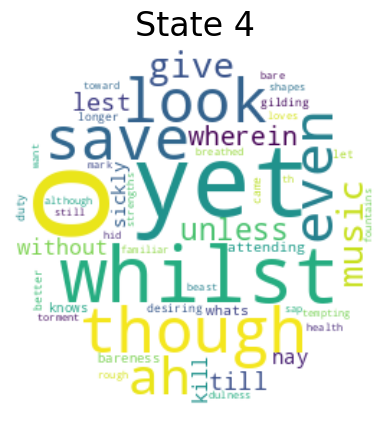

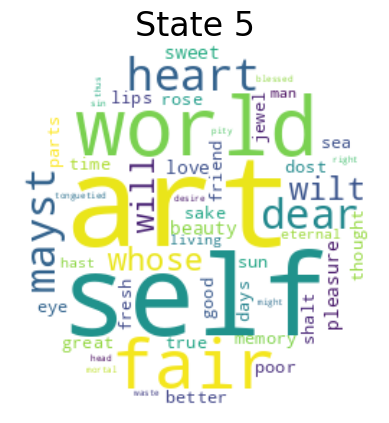

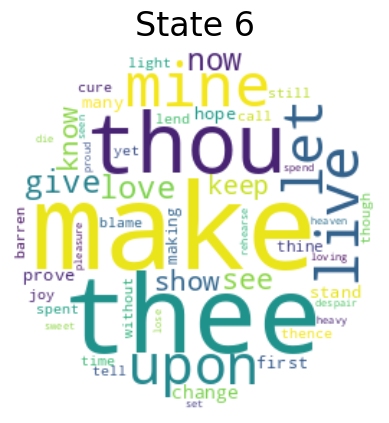

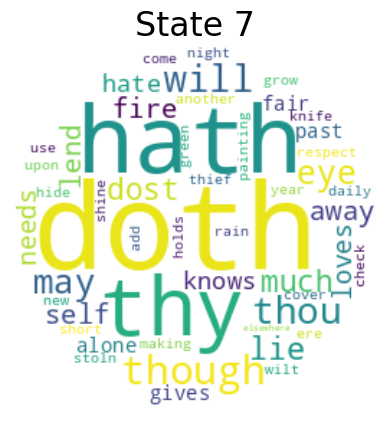

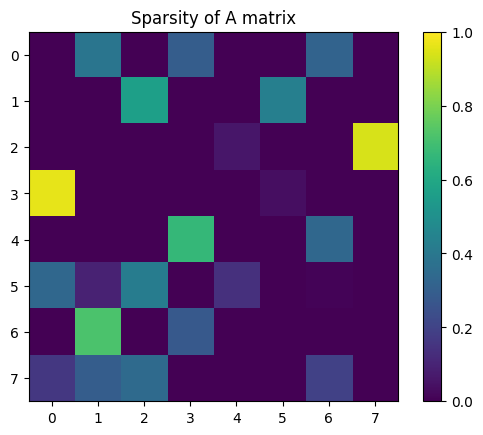

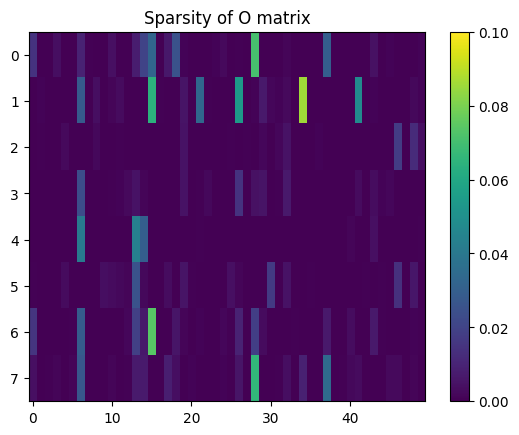

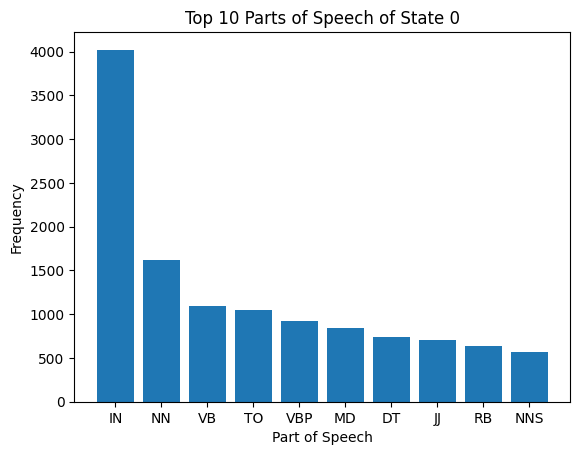

{'DT': 'determiner',
 'IN': 'preposition or conjunction, subordinating',
 'JJ': 'adjective or numeral, ordinal',
 'MD': 'modal auxiliary',
 'NN': 'noun, common, singular or mass',
 'NNS': 'noun, common, plural',
 'RB': 'adverb',
 'TO': '"to" as preposition or infinitive marker',
 'VB': 'verb, base form',
 'VBP': 'verb, present tense, not 3rd person singular'}


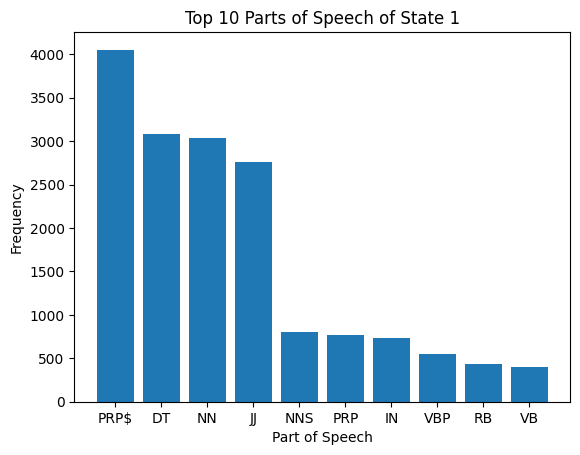

{'DT': 'determiner',
 'IN': 'preposition or conjunction, subordinating',
 'JJ': 'adjective or numeral, ordinal',
 'NN': 'noun, common, singular or mass',
 'NNS': 'noun, common, plural',
 'PRP': 'pronoun, personal',
 'PRP$': 'pronoun, possessive',
 'RB': 'adverb',
 'VB': 'verb, base form',
 'VBP': 'verb, present tense, not 3rd person singular'}


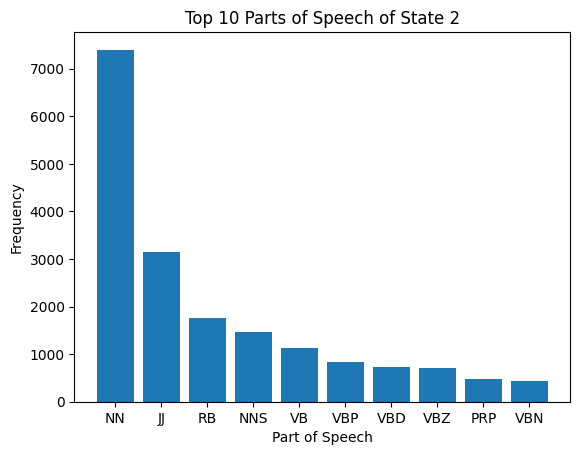

{'JJ': 'adjective or numeral, ordinal',
 'NN': 'noun, common, singular or mass',
 'NNS': 'noun, common, plural',
 'PRP': 'pronoun, personal',
 'RB': 'adverb',
 'VB': 'verb, base form',
 'VBD': 'verb, past tense',
 'VBN': 'verb, past participle',
 'VBP': 'verb, present tense, not 3rd person singular',
 'VBZ': 'verb, present tense, 3rd person singular'}


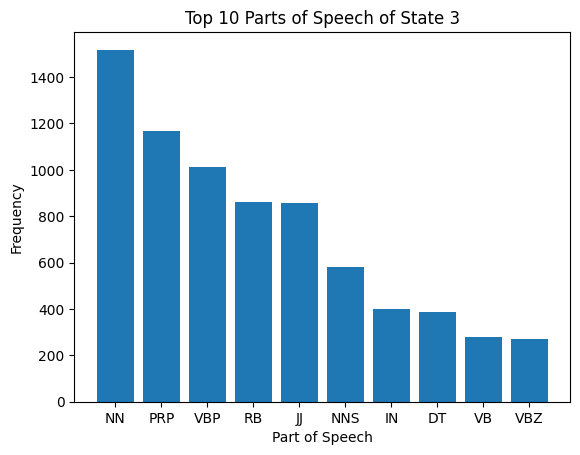

{'DT': 'determiner',
 'IN': 'preposition or conjunction, subordinating',
 'JJ': 'adjective or numeral, ordinal',
 'NN': 'noun, common, singular or mass',
 'NNS': 'noun, common, plural',
 'PRP': 'pronoun, personal',
 'RB': 'adverb',
 'VB': 'verb, base form',
 'VBP': 'verb, present tense, not 3rd person singular',
 'VBZ': 'verb, present tense, 3rd person singular'}


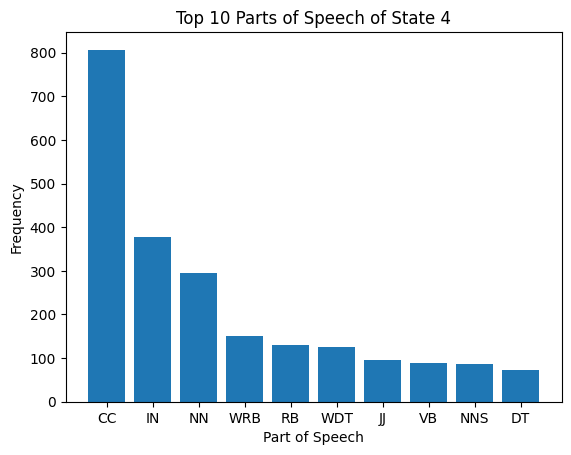

{'CC': 'conjunction, coordinating',
 'DT': 'determiner',
 'IN': 'preposition or conjunction, subordinating',
 'JJ': 'adjective or numeral, ordinal',
 'NN': 'noun, common, singular or mass',
 'NNS': 'noun, common, plural',
 'RB': 'adverb',
 'VB': 'verb, base form',
 'WDT': 'WH-determiner',
 'WRB': 'Wh-adverb'}


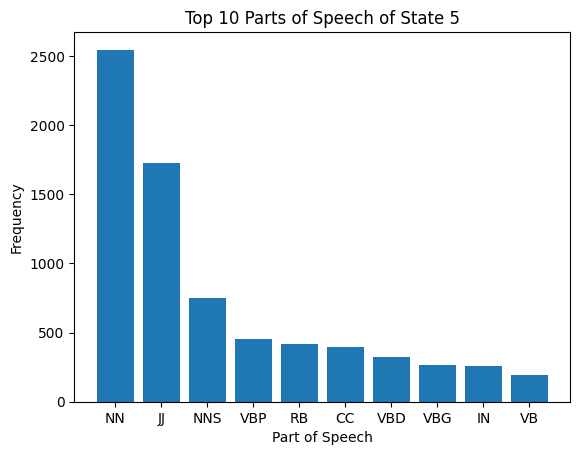

{'CC': 'conjunction, coordinating',
 'IN': 'preposition or conjunction, subordinating',
 'JJ': 'adjective or numeral, ordinal',
 'NN': 'noun, common, singular or mass',
 'NNS': 'noun, common, plural',
 'RB': 'adverb',
 'VB': 'verb, base form',
 'VBD': 'verb, past tense',
 'VBG': 'verb, present participle or gerund',
 'VBP': 'verb, present tense, not 3rd person singular'}


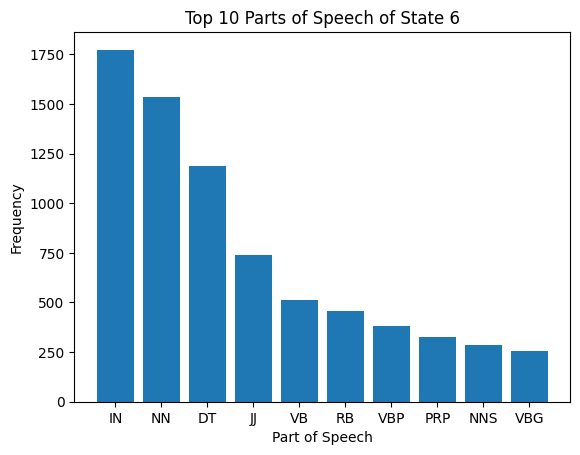

{'DT': 'determiner',
 'IN': 'preposition or conjunction, subordinating',
 'JJ': 'adjective or numeral, ordinal',
 'NN': 'noun, common, singular or mass',
 'NNS': 'noun, common, plural',
 'PRP': 'pronoun, personal',
 'RB': 'adverb',
 'VB': 'verb, base form',
 'VBG': 'verb, present participle or gerund',
 'VBP': 'verb, present tense, not 3rd person singular'}


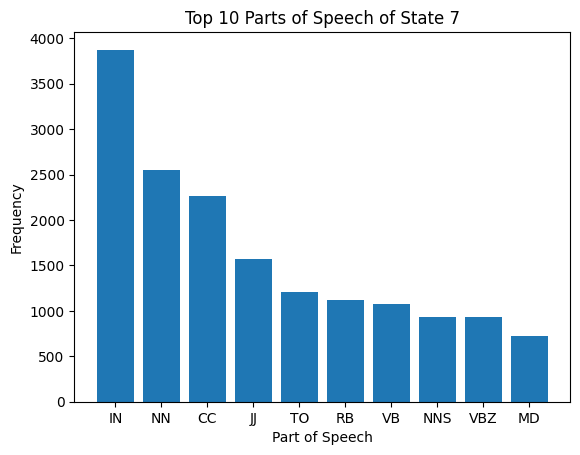

{'CC': 'conjunction, coordinating',
 'IN': 'preposition or conjunction, subordinating',
 'JJ': 'adjective or numeral, ordinal',
 'MD': 'modal auxiliary',
 'NN': 'noun, common, singular or mass',
 'NNS': 'noun, common, plural',
 'RB': 'adverb',
 'TO': '"to" as preposition or infinitive marker',
 'VB': 'verb, base form',
 'VBZ': 'verb, present tense, 3rd person singular'}


In [ ]:
wordcloud8 = states_to_wordclouds(hmm8, obs_map)
visualize_sparsities(hmm8, O_max_cols=50)
pos8 = states_to_POS(hmm8, obs_map)
visualize_pos(pos8, tagdict)

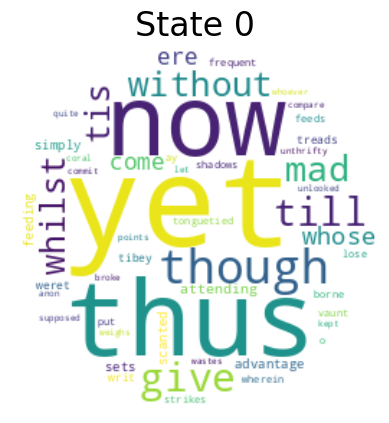

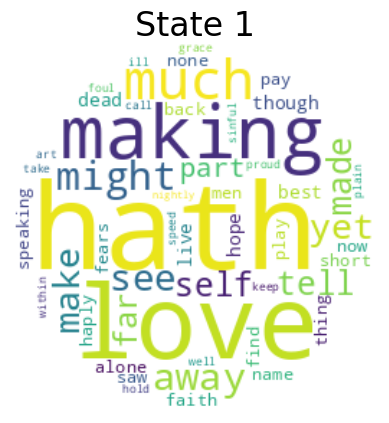

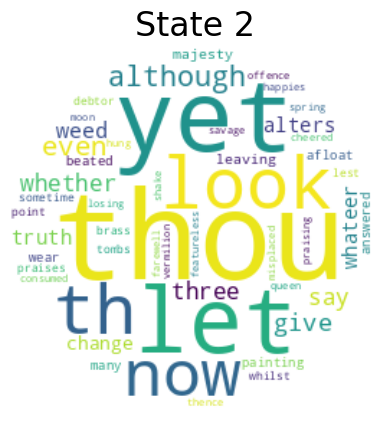

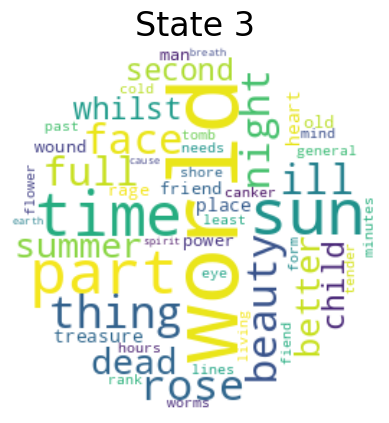

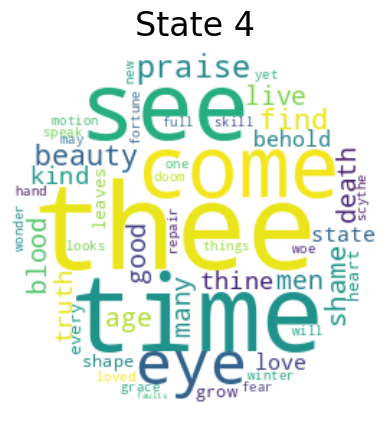

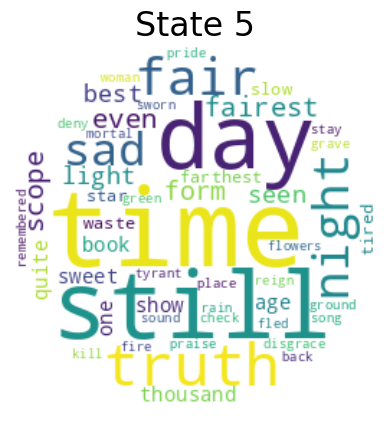

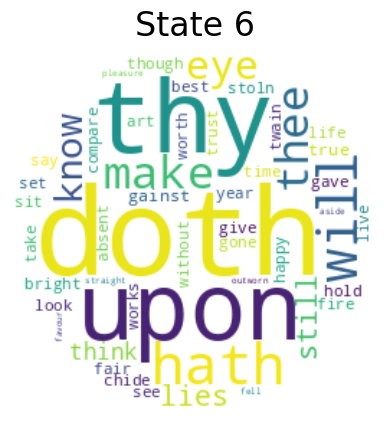

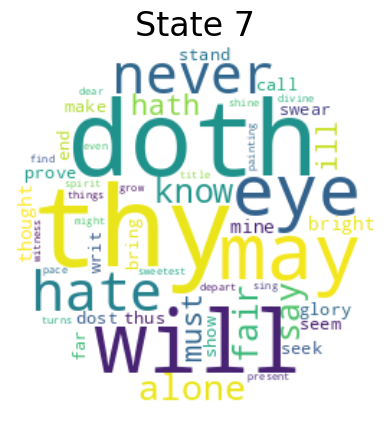

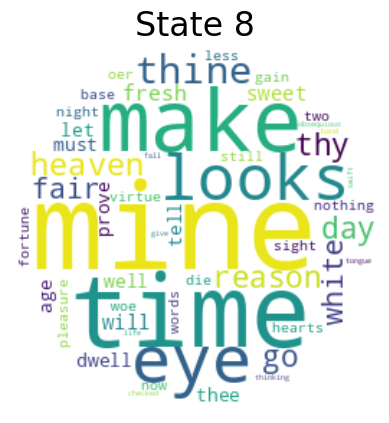

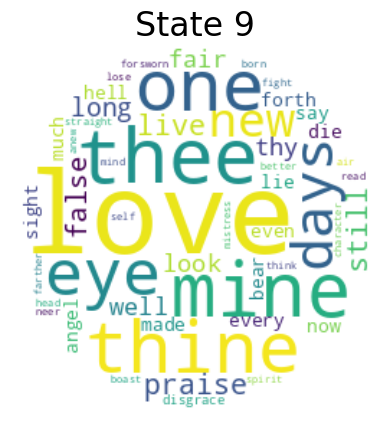

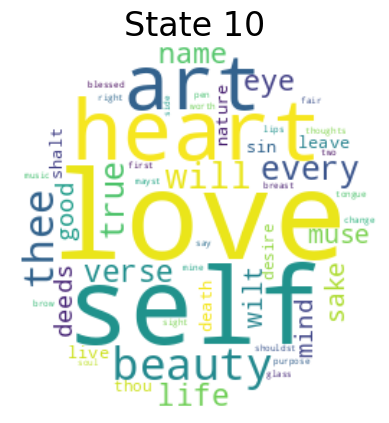

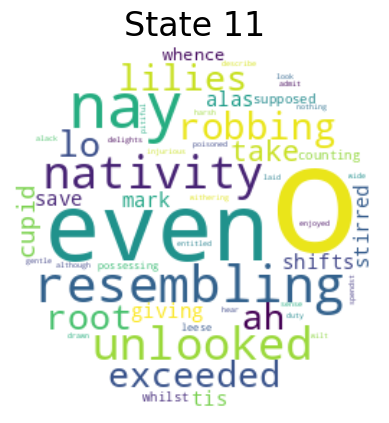

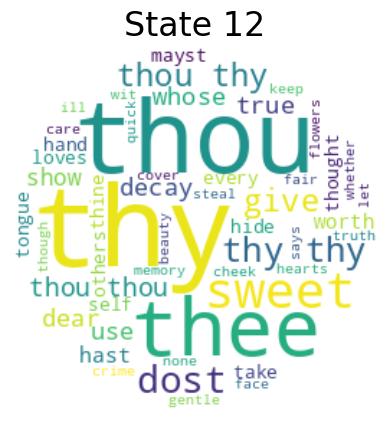

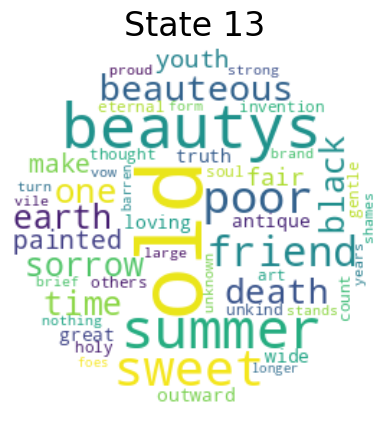

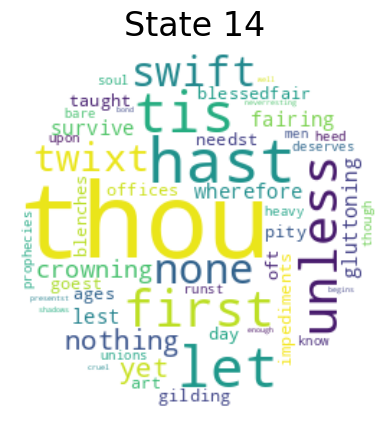

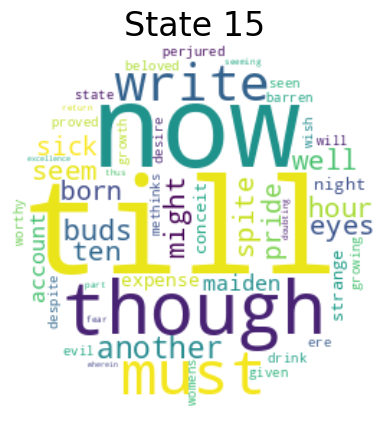

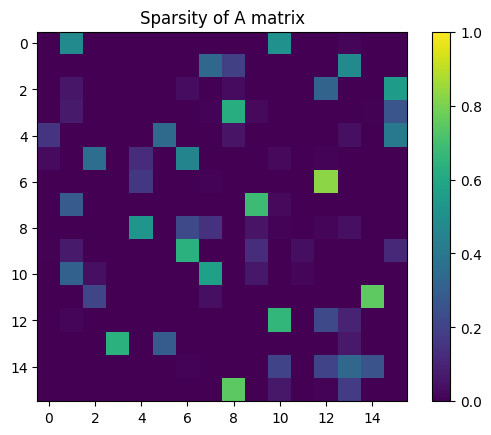

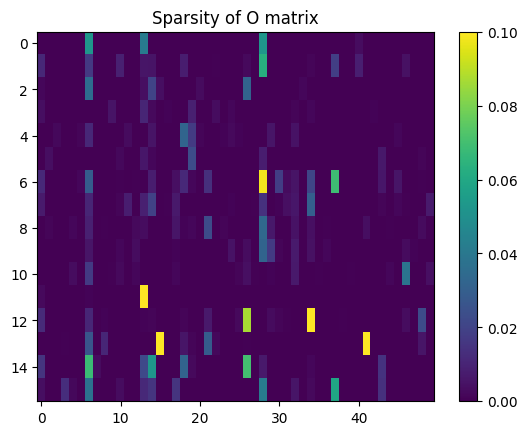

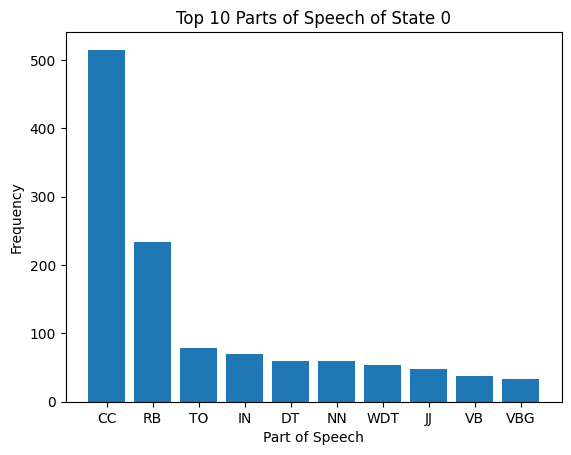

{'CC': 'conjunction, coordinating',
 'DT': 'determiner',
 'IN': 'preposition or conjunction, subordinating',
 'JJ': 'adjective or numeral, ordinal',
 'NN': 'noun, common, singular or mass',
 'RB': 'adverb',
 'TO': '"to" as preposition or infinitive marker',
 'VB': 'verb, base form',
 'VBG': 'verb, present participle or gerund',
 'WDT': 'WH-determiner'}


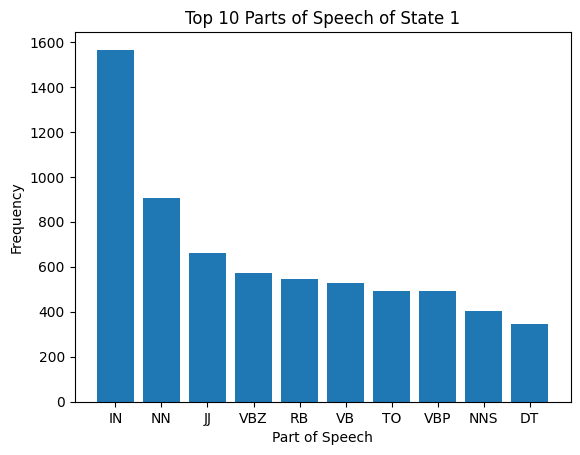

{'DT': 'determiner',
 'IN': 'preposition or conjunction, subordinating',
 'JJ': 'adjective or numeral, ordinal',
 'NN': 'noun, common, singular or mass',
 'NNS': 'noun, common, plural',
 'RB': 'adverb',
 'TO': '"to" as preposition or infinitive marker',
 'VB': 'verb, base form',
 'VBP': 'verb, present tense, not 3rd person singular',
 'VBZ': 'verb, present tense, 3rd person singular'}


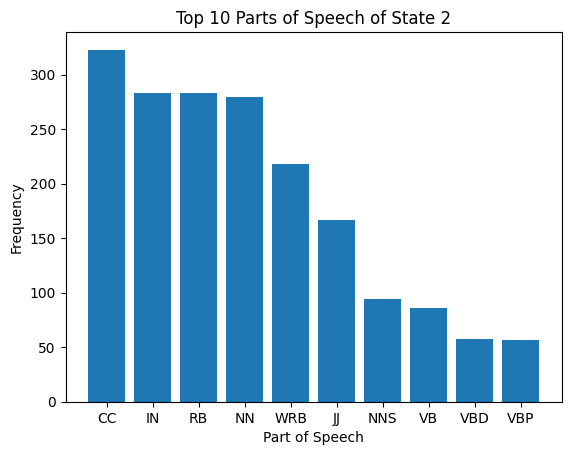

{'CC': 'conjunction, coordinating',
 'IN': 'preposition or conjunction, subordinating',
 'JJ': 'adjective or numeral, ordinal',
 'NN': 'noun, common, singular or mass',
 'NNS': 'noun, common, plural',
 'RB': 'adverb',
 'VB': 'verb, base form',
 'VBD': 'verb, past tense',
 'VBP': 'verb, present tense, not 3rd person singular',
 'WRB': 'Wh-adverb'}


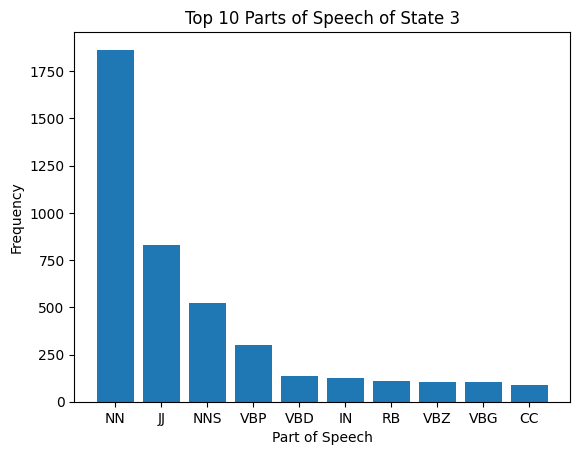

{'CC': 'conjunction, coordinating',
 'IN': 'preposition or conjunction, subordinating',
 'JJ': 'adjective or numeral, ordinal',
 'NN': 'noun, common, singular or mass',
 'NNS': 'noun, common, plural',
 'RB': 'adverb',
 'VBD': 'verb, past tense',
 'VBG': 'verb, present participle or gerund',
 'VBP': 'verb, present tense, not 3rd person singular',
 'VBZ': 'verb, present tense, 3rd person singular'}


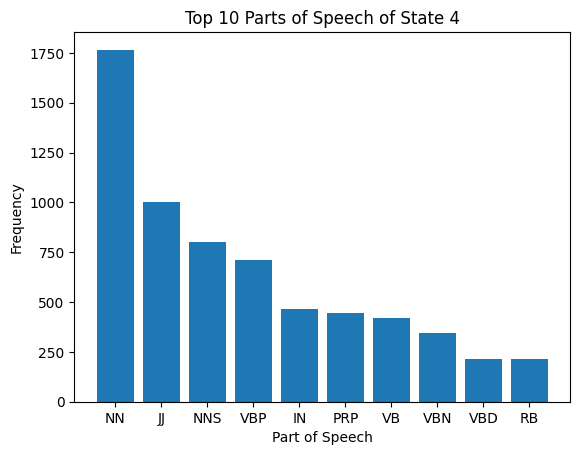

{'IN': 'preposition or conjunction, subordinating',
 'JJ': 'adjective or numeral, ordinal',
 'NN': 'noun, common, singular or mass',
 'NNS': 'noun, common, plural',
 'PRP': 'pronoun, personal',
 'RB': 'adverb',
 'VB': 'verb, base form',
 'VBD': 'verb, past tense',
 'VBN': 'verb, past participle',
 'VBP': 'verb, present tense, not 3rd person singular'}


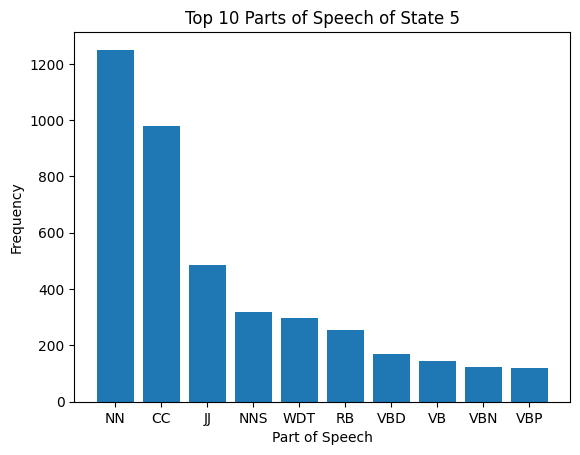

{'CC': 'conjunction, coordinating',
 'JJ': 'adjective or numeral, ordinal',
 'NN': 'noun, common, singular or mass',
 'NNS': 'noun, common, plural',
 'RB': 'adverb',
 'VB': 'verb, base form',
 'VBD': 'verb, past tense',
 'VBN': 'verb, past participle',
 'VBP': 'verb, present tense, not 3rd person singular',
 'WDT': 'WH-determiner'}


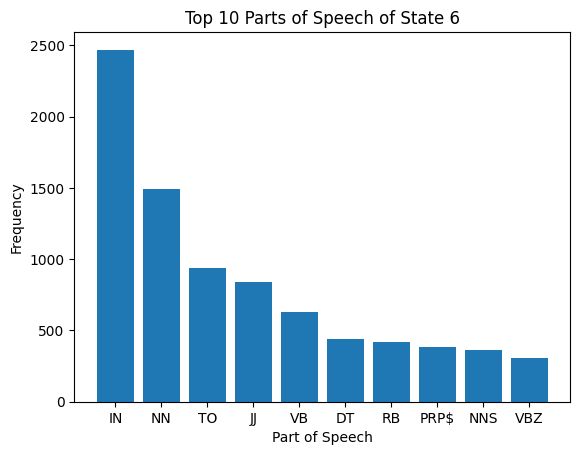

{'DT': 'determiner',
 'IN': 'preposition or conjunction, subordinating',
 'JJ': 'adjective or numeral, ordinal',
 'NN': 'noun, common, singular or mass',
 'NNS': 'noun, common, plural',
 'PRP$': 'pronoun, possessive',
 'RB': 'adverb',
 'TO': '"to" as preposition or infinitive marker',
 'VB': 'verb, base form',
 'VBZ': 'verb, present tense, 3rd person singular'}


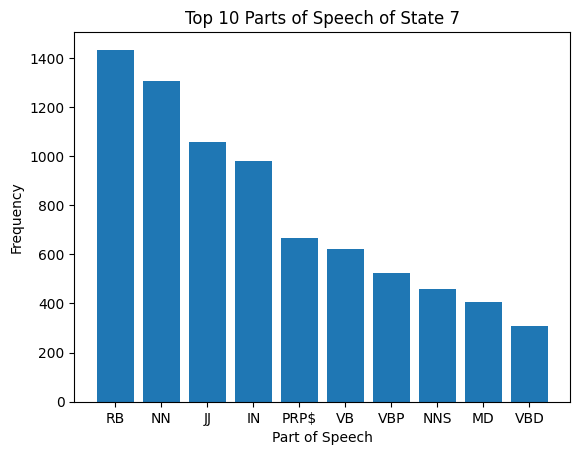

{'IN': 'preposition or conjunction, subordinating',
 'JJ': 'adjective or numeral, ordinal',
 'MD': 'modal auxiliary',
 'NN': 'noun, common, singular or mass',
 'NNS': 'noun, common, plural',
 'PRP$': 'pronoun, possessive',
 'RB': 'adverb',
 'VB': 'verb, base form',
 'VBD': 'verb, past tense',
 'VBP': 'verb, present tense, not 3rd person singular'}


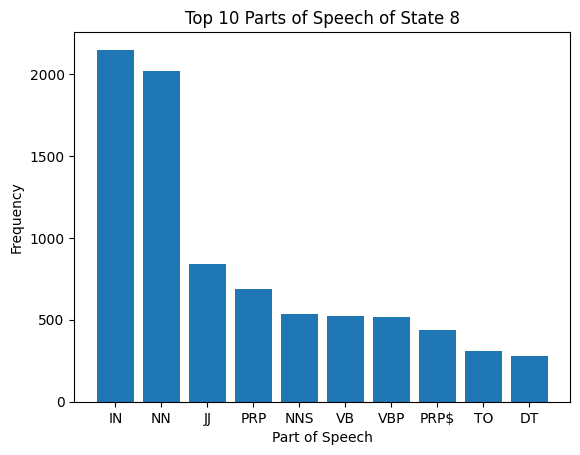

{'DT': 'determiner',
 'IN': 'preposition or conjunction, subordinating',
 'JJ': 'adjective or numeral, ordinal',
 'NN': 'noun, common, singular or mass',
 'NNS': 'noun, common, plural',
 'PRP': 'pronoun, personal',
 'PRP$': 'pronoun, possessive',
 'TO': '"to" as preposition or infinitive marker',
 'VB': 'verb, base form',
 'VBP': 'verb, present tense, not 3rd person singular'}


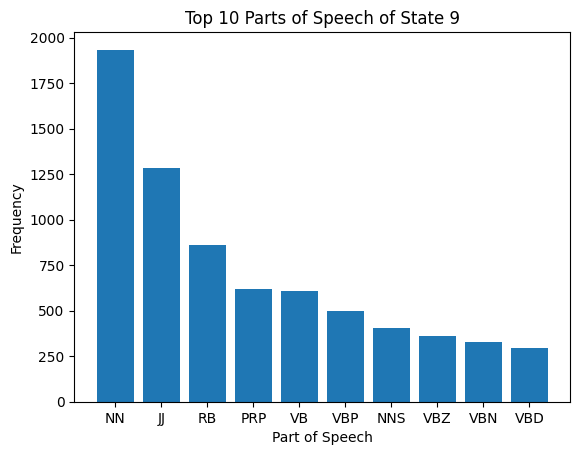

{'JJ': 'adjective or numeral, ordinal',
 'NN': 'noun, common, singular or mass',
 'NNS': 'noun, common, plural',
 'PRP': 'pronoun, personal',
 'RB': 'adverb',
 'VB': 'verb, base form',
 'VBD': 'verb, past tense',
 'VBN': 'verb, past participle',
 'VBP': 'verb, present tense, not 3rd person singular',
 'VBZ': 'verb, present tense, 3rd person singular'}


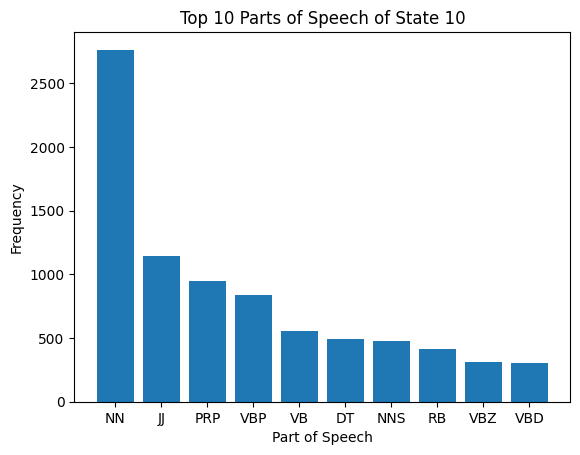

{'DT': 'determiner',
 'JJ': 'adjective or numeral, ordinal',
 'NN': 'noun, common, singular or mass',
 'NNS': 'noun, common, plural',
 'PRP': 'pronoun, personal',
 'RB': 'adverb',
 'VB': 'verb, base form',
 'VBD': 'verb, past tense',
 'VBP': 'verb, present tense, not 3rd person singular',
 'VBZ': 'verb, present tense, 3rd person singular'}


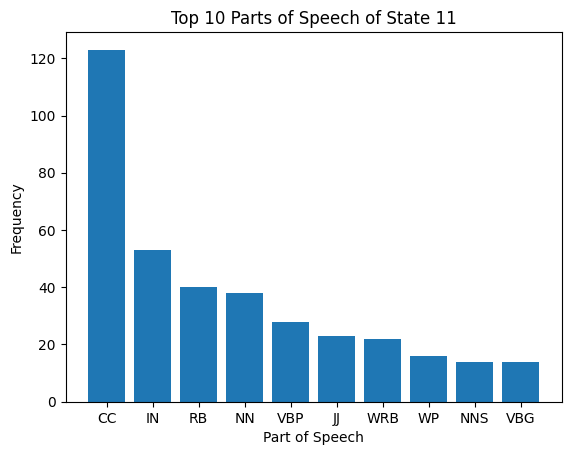

{'CC': 'conjunction, coordinating',
 'IN': 'preposition or conjunction, subordinating',
 'JJ': 'adjective or numeral, ordinal',
 'NN': 'noun, common, singular or mass',
 'NNS': 'noun, common, plural',
 'RB': 'adverb',
 'VBG': 'verb, present participle or gerund',
 'VBP': 'verb, present tense, not 3rd person singular',
 'WP': 'WH-pronoun',
 'WRB': 'Wh-adverb'}


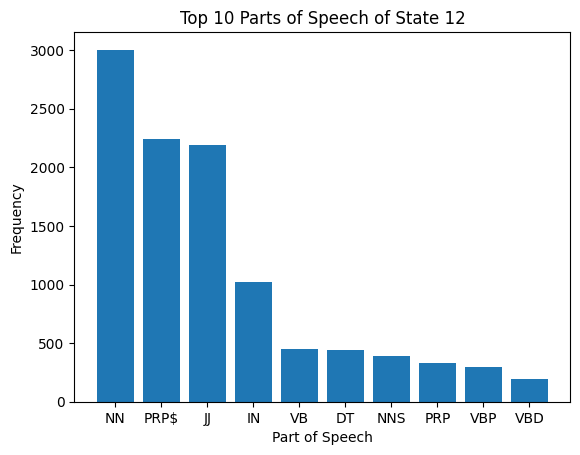

{'DT': 'determiner',
 'IN': 'preposition or conjunction, subordinating',
 'JJ': 'adjective or numeral, ordinal',
 'NN': 'noun, common, singular or mass',
 'NNS': 'noun, common, plural',
 'PRP': 'pronoun, personal',
 'PRP$': 'pronoun, possessive',
 'VB': 'verb, base form',
 'VBD': 'verb, past tense',
 'VBP': 'verb, present tense, not 3rd person singular'}


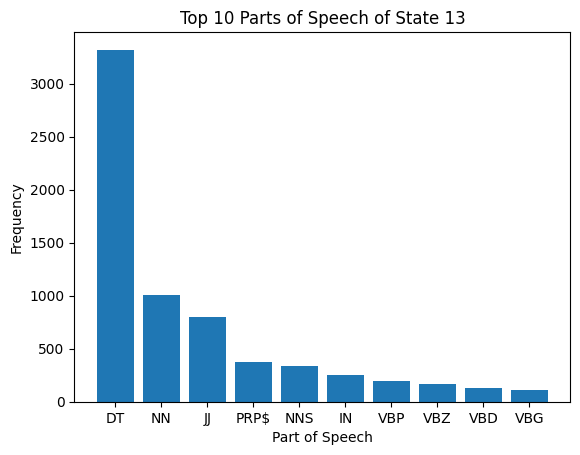

{'DT': 'determiner',
 'IN': 'preposition or conjunction, subordinating',
 'JJ': 'adjective or numeral, ordinal',
 'NN': 'noun, common, singular or mass',
 'NNS': 'noun, common, plural',
 'PRP$': 'pronoun, possessive',
 'VBD': 'verb, past tense',
 'VBG': 'verb, present participle or gerund',
 'VBP': 'verb, present tense, not 3rd person singular',
 'VBZ': 'verb, present tense, 3rd person singular'}


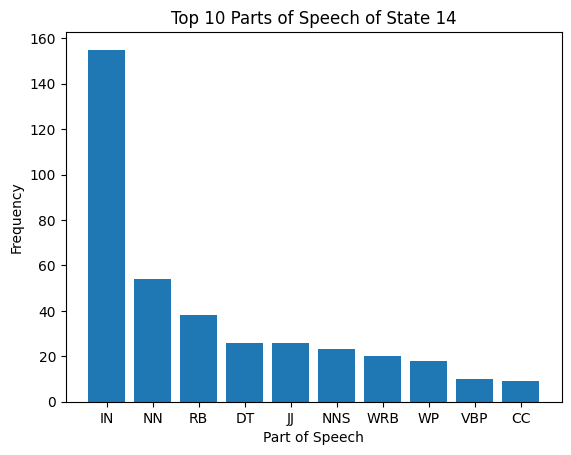

{'CC': 'conjunction, coordinating',
 'DT': 'determiner',
 'IN': 'preposition or conjunction, subordinating',
 'JJ': 'adjective or numeral, ordinal',
 'NN': 'noun, common, singular or mass',
 'NNS': 'noun, common, plural',
 'RB': 'adverb',
 'VBP': 'verb, present tense, not 3rd person singular',
 'WP': 'WH-pronoun',
 'WRB': 'Wh-adverb'}


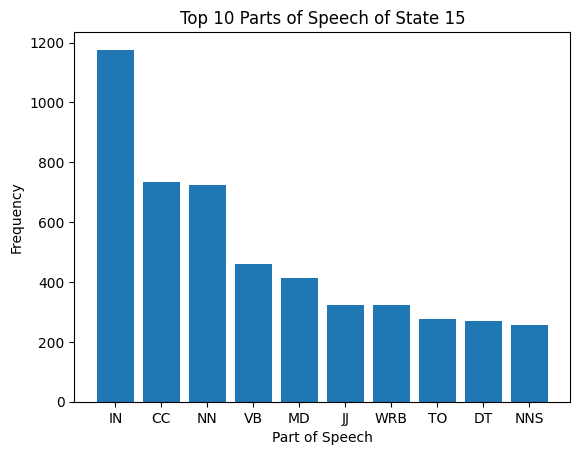

{'CC': 'conjunction, coordinating',
 'DT': 'determiner',
 'IN': 'preposition or conjunction, subordinating',
 'JJ': 'adjective or numeral, ordinal',
 'MD': 'modal auxiliary',
 'NN': 'noun, common, singular or mass',
 'NNS': 'noun, common, plural',
 'TO': '"to" as preposition or infinitive marker',
 'VB': 'verb, base form',
 'WRB': 'Wh-adverb'}


In [ ]:
wordcloud16 = states_to_wordclouds(hmm16, obs_map)
visualize_sparsities(hmm16, O_max_cols=50)
pos16 = states_to_POS(hmm16, obs_map)
visualize_pos(pos16, tagdict)


Animating...


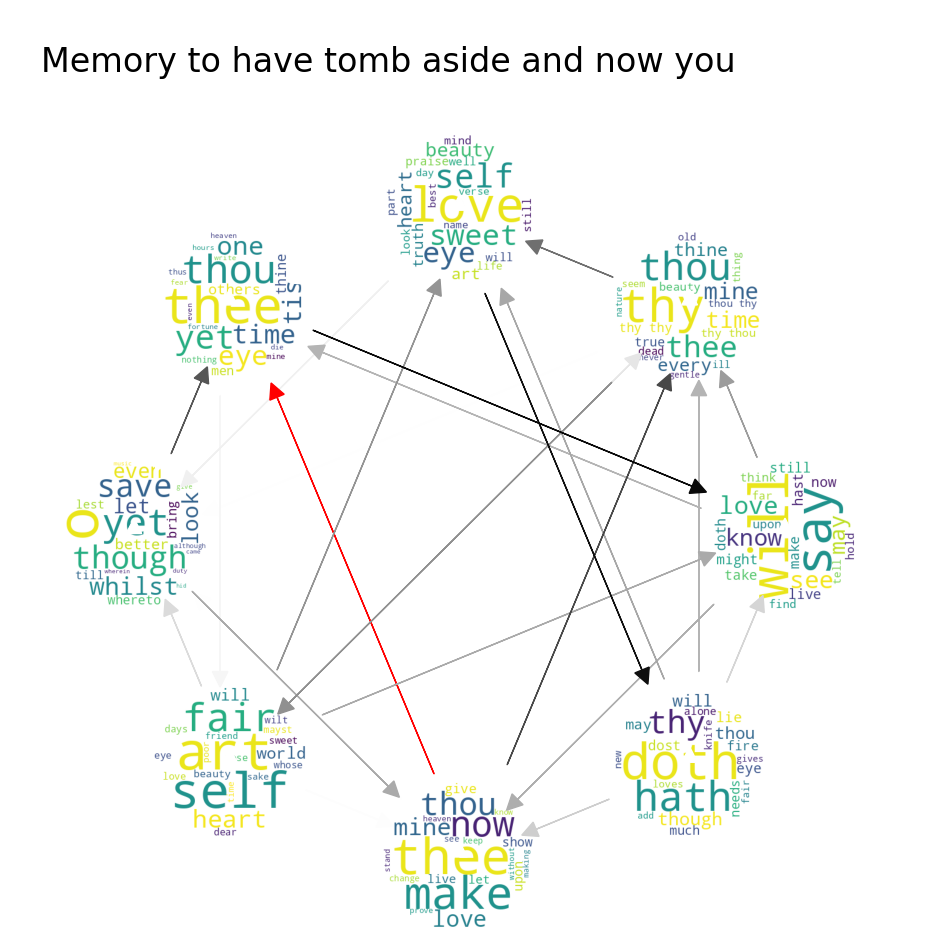

In [ ]:
from IPython.display import HTML
anim = animate_emission(hmm8, obs_map, M=8, seed=123)
HTML(anim.to_html5_video())

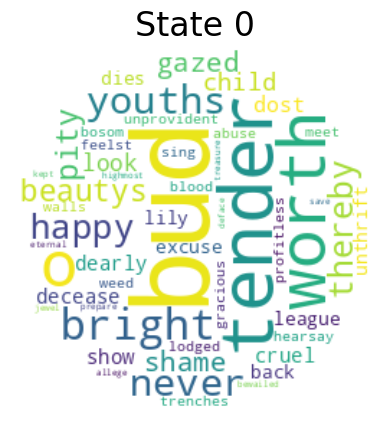

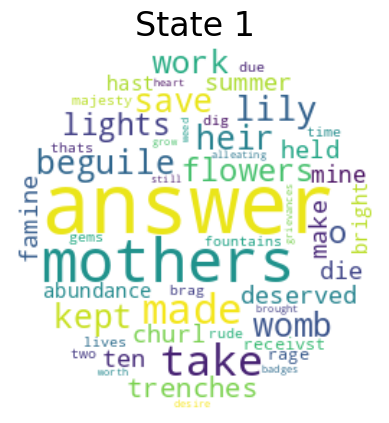

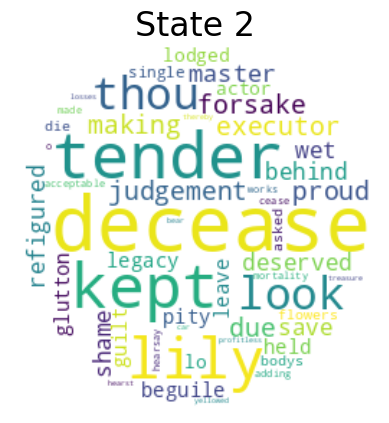

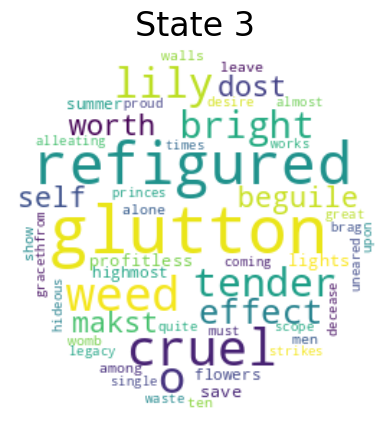

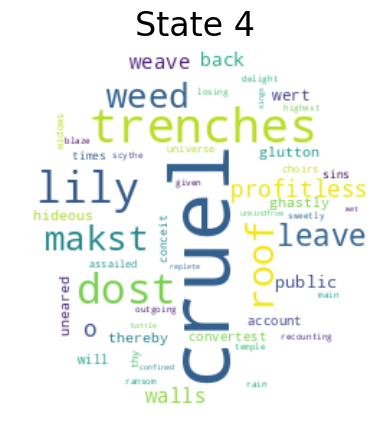

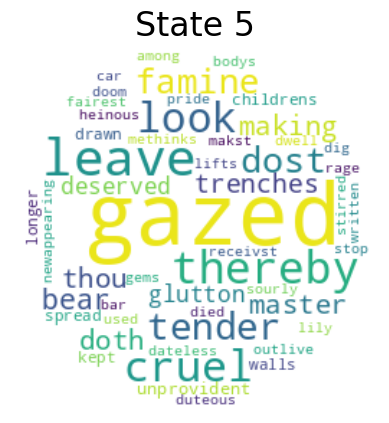

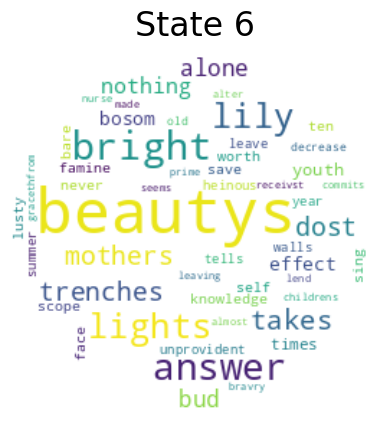

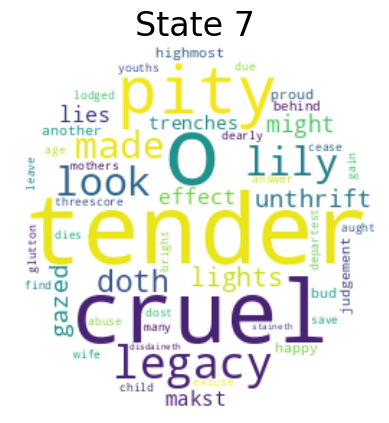

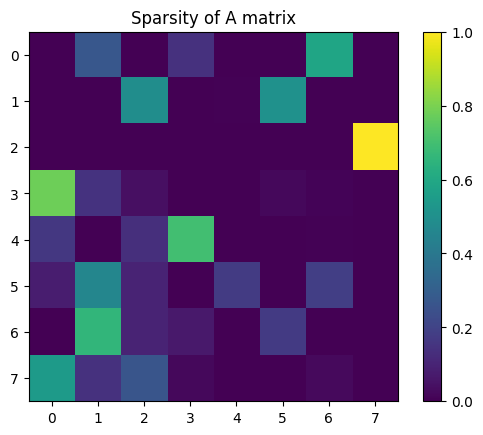

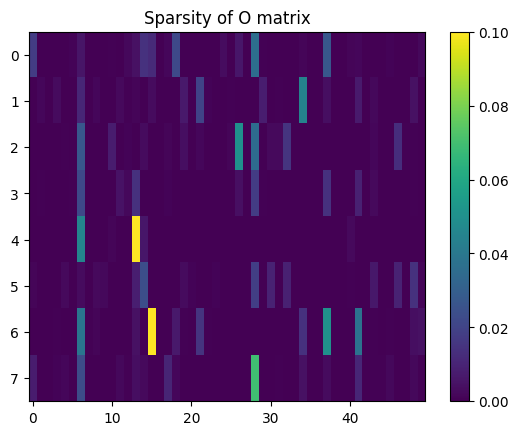

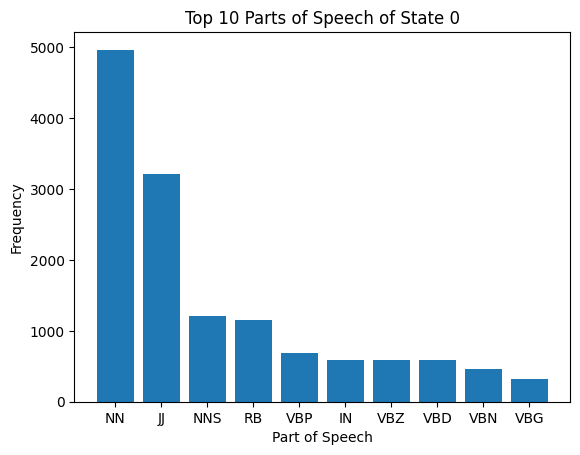

{'IN': 'preposition or conjunction, subordinating',
 'JJ': 'adjective or numeral, ordinal',
 'NN': 'noun, common, singular or mass',
 'NNS': 'noun, common, plural',
 'RB': 'adverb',
 'VBD': 'verb, past tense',
 'VBG': 'verb, present participle or gerund',
 'VBN': 'verb, past participle',
 'VBP': 'verb, present tense, not 3rd person singular',
 'VBZ': 'verb, present tense, 3rd person singular'}


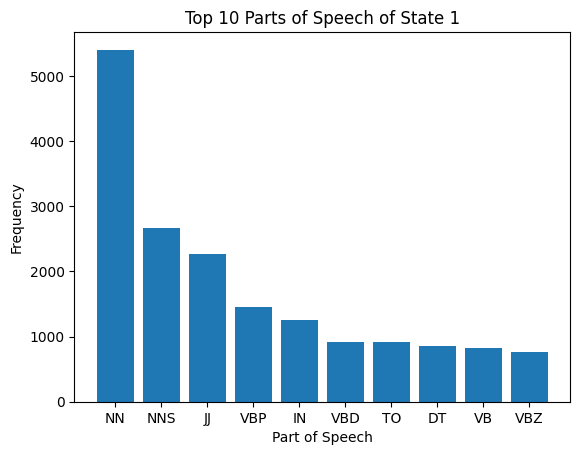

{'DT': 'determiner',
 'IN': 'preposition or conjunction, subordinating',
 'JJ': 'adjective or numeral, ordinal',
 'NN': 'noun, common, singular or mass',
 'NNS': 'noun, common, plural',
 'TO': '"to" as preposition or infinitive marker',
 'VB': 'verb, base form',
 'VBD': 'verb, past tense',
 'VBP': 'verb, present tense, not 3rd person singular',
 'VBZ': 'verb, present tense, 3rd person singular'}


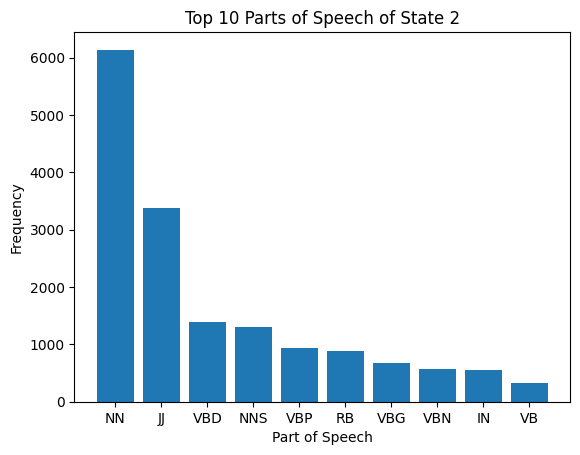

{'IN': 'preposition or conjunction, subordinating',
 'JJ': 'adjective or numeral, ordinal',
 'NN': 'noun, common, singular or mass',
 'NNS': 'noun, common, plural',
 'RB': 'adverb',
 'VB': 'verb, base form',
 'VBD': 'verb, past tense',
 'VBG': 'verb, present participle or gerund',
 'VBN': 'verb, past participle',
 'VBP': 'verb, present tense, not 3rd person singular'}


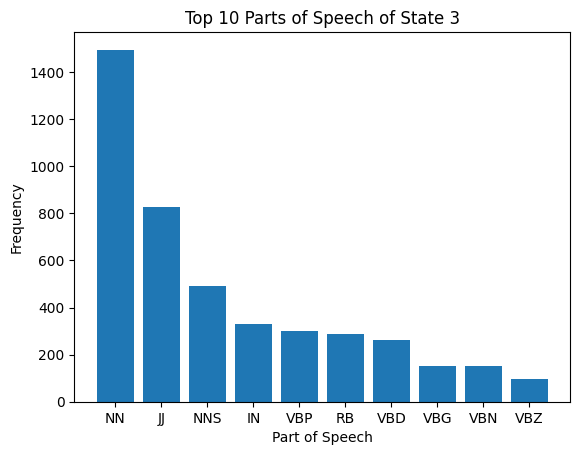

{'IN': 'preposition or conjunction, subordinating',
 'JJ': 'adjective or numeral, ordinal',
 'NN': 'noun, common, singular or mass',
 'NNS': 'noun, common, plural',
 'RB': 'adverb',
 'VBD': 'verb, past tense',
 'VBG': 'verb, present participle or gerund',
 'VBN': 'verb, past participle',
 'VBP': 'verb, present tense, not 3rd person singular',
 'VBZ': 'verb, present tense, 3rd person singular'}


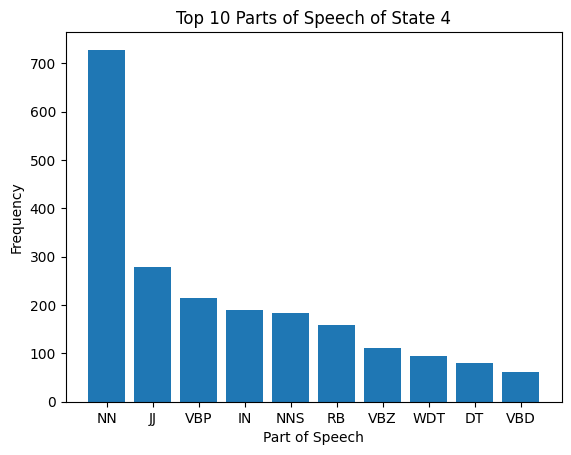

{'DT': 'determiner',
 'IN': 'preposition or conjunction, subordinating',
 'JJ': 'adjective or numeral, ordinal',
 'NN': 'noun, common, singular or mass',
 'NNS': 'noun, common, plural',
 'RB': 'adverb',
 'VBD': 'verb, past tense',
 'VBP': 'verb, present tense, not 3rd person singular',
 'VBZ': 'verb, present tense, 3rd person singular',
 'WDT': 'WH-determiner'}


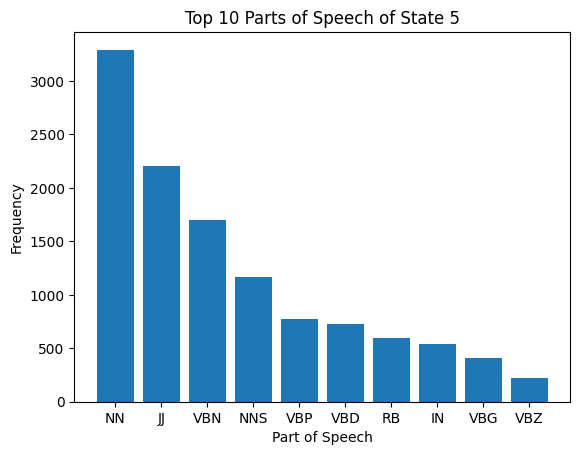

{'IN': 'preposition or conjunction, subordinating',
 'JJ': 'adjective or numeral, ordinal',
 'NN': 'noun, common, singular or mass',
 'NNS': 'noun, common, plural',
 'RB': 'adverb',
 'VBD': 'verb, past tense',
 'VBG': 'verb, present participle or gerund',
 'VBN': 'verb, past participle',
 'VBP': 'verb, present tense, not 3rd person singular',
 'VBZ': 'verb, present tense, 3rd person singular'}


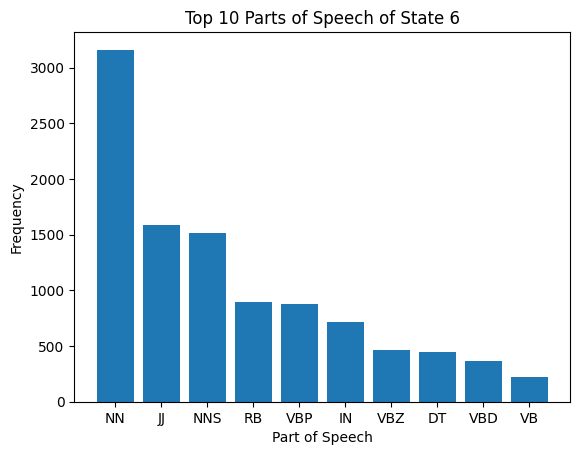

{'DT': 'determiner',
 'IN': 'preposition or conjunction, subordinating',
 'JJ': 'adjective or numeral, ordinal',
 'NN': 'noun, common, singular or mass',
 'NNS': 'noun, common, plural',
 'RB': 'adverb',
 'VB': 'verb, base form',
 'VBD': 'verb, past tense',
 'VBP': 'verb, present tense, not 3rd person singular',
 'VBZ': 'verb, present tense, 3rd person singular'}


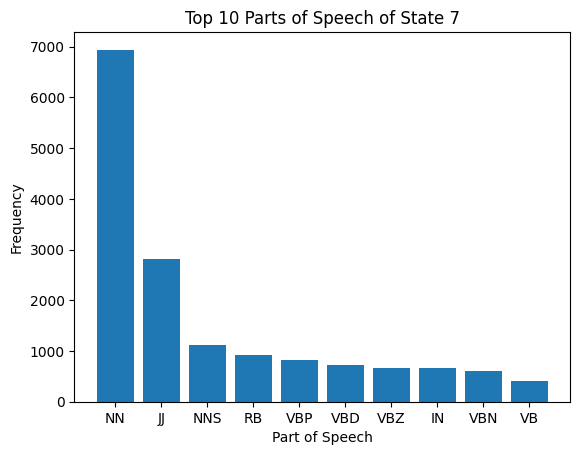

{'IN': 'preposition or conjunction, subordinating',
 'JJ': 'adjective or numeral, ordinal',
 'NN': 'noun, common, singular or mass',
 'NNS': 'noun, common, plural',
 'RB': 'adverb',
 'VB': 'verb, base form',
 'VBD': 'verb, past tense',
 'VBN': 'verb, past participle',
 'VBP': 'verb, present tense, not 3rd person singular',
 'VBZ': 'verb, present tense, 3rd person singular'}


In [ ]:
wordcloud_add = states_to_wordclouds(hmm_add, obs_map2)
visualize_sparsities(hmm_add, O_max_cols=50)
pos_add = states_to_POS(hmm_add, obs_map2)
visualize_pos(pos_add, tagdict)

### Other Poetic Forms (Haiku)

In [ ]:
def generate_haiku_naive(hmm, syllable_dict, obs_map, seed):
    np.random.seed(seed)
    seed_add = np.random.randint(1000)

    haiku = [None] * 3

    haiku[0] = sample_line(hmm, syllable_dict, obs_map, 5, seed + seed_add)
    haiku[1] = sample_line(hmm, syllable_dict, obs_map, 7, seed + 1 + seed_add)
    haiku[2] = sample_line(hmm, syllable_dict, obs_map, 5, seed + 2 + seed_add)

    return haiku


hmm = load_model('hmm8.pkl')
haiku = generate_haiku_naive(hmm, syllable_dict, obs_map, seed=10)
print_poem(haiku)

Boast as hymns thy eye
But ill eye delivers brain
And his are thou yours


### Additional Text (spenser.txt)

In [ ]:
shakespeare = get_text('shakespeare.txt')
spenser = get_text('spenser.txt')

full_text = shakespeare + spenser
obs, obs_map = parse_observations(full_text)

hmm_add_text = load_model('hmm_add_text.pkl')

sonnet = generate_sonnet_rhyme(hmm_add_text, syllable_dict, rhyme_dict, obs_map, seed=1)
print_poem(sonnet)

So lacked tear her earth aid worth than minds time
With grief your lease grounded all mine one I
Minds than worth aid earth her tear sake hate crime
Her will she unto such have black she ay

Or I lips bad and girded my king once
Presagers removed but unbless to of
Even in elsewhere deepest truth of conscience
And part thine on to grace eternal dove

In the your under to adverse wrong spoil
Hanging that and with wrack than than why I
My move I space eyes they thought proud fair soil
Why than than wrack new I to die me aye

  Love finding no love ornaments some rage
  Some ornaments love no finding love stage
